In [1]:
import sys
sys.path.append('../.')


from utils import *
from utils_plotting import *
from Data.DataGenerator import *
from Models.Models_normal import *
import torch.optim as optim
from Training.Analysis import fixed_model_batch_analysis
from Data.DataLoader import *
from Training.Spike_loss import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor


In [2]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])

model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/november_res/mnist/normal/bias_0.0001/mnist_training/try_num2/epoch_120/model.pt', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()



dataset_target_samples = train_samples
dataset_target_labels = train_labels

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


{'x': [-2346.6785, 10243.8125], 'y': [-6215.287, 5770.5586]}
{'x': [-0.42421296, 3666.1433], 'y': [-0.42421296, 4605.0923]}
{'x': [-2346.6785, 10243.8125], 'y': [-6215.287, 5770.5586], 'z': [-4848.4746, 4951.2812]}
{'x': [-0.42421296, 2407.6497], 'y': [-0.42421296, 5544.9395], 'z': [-0.42421296, 4692.031]}


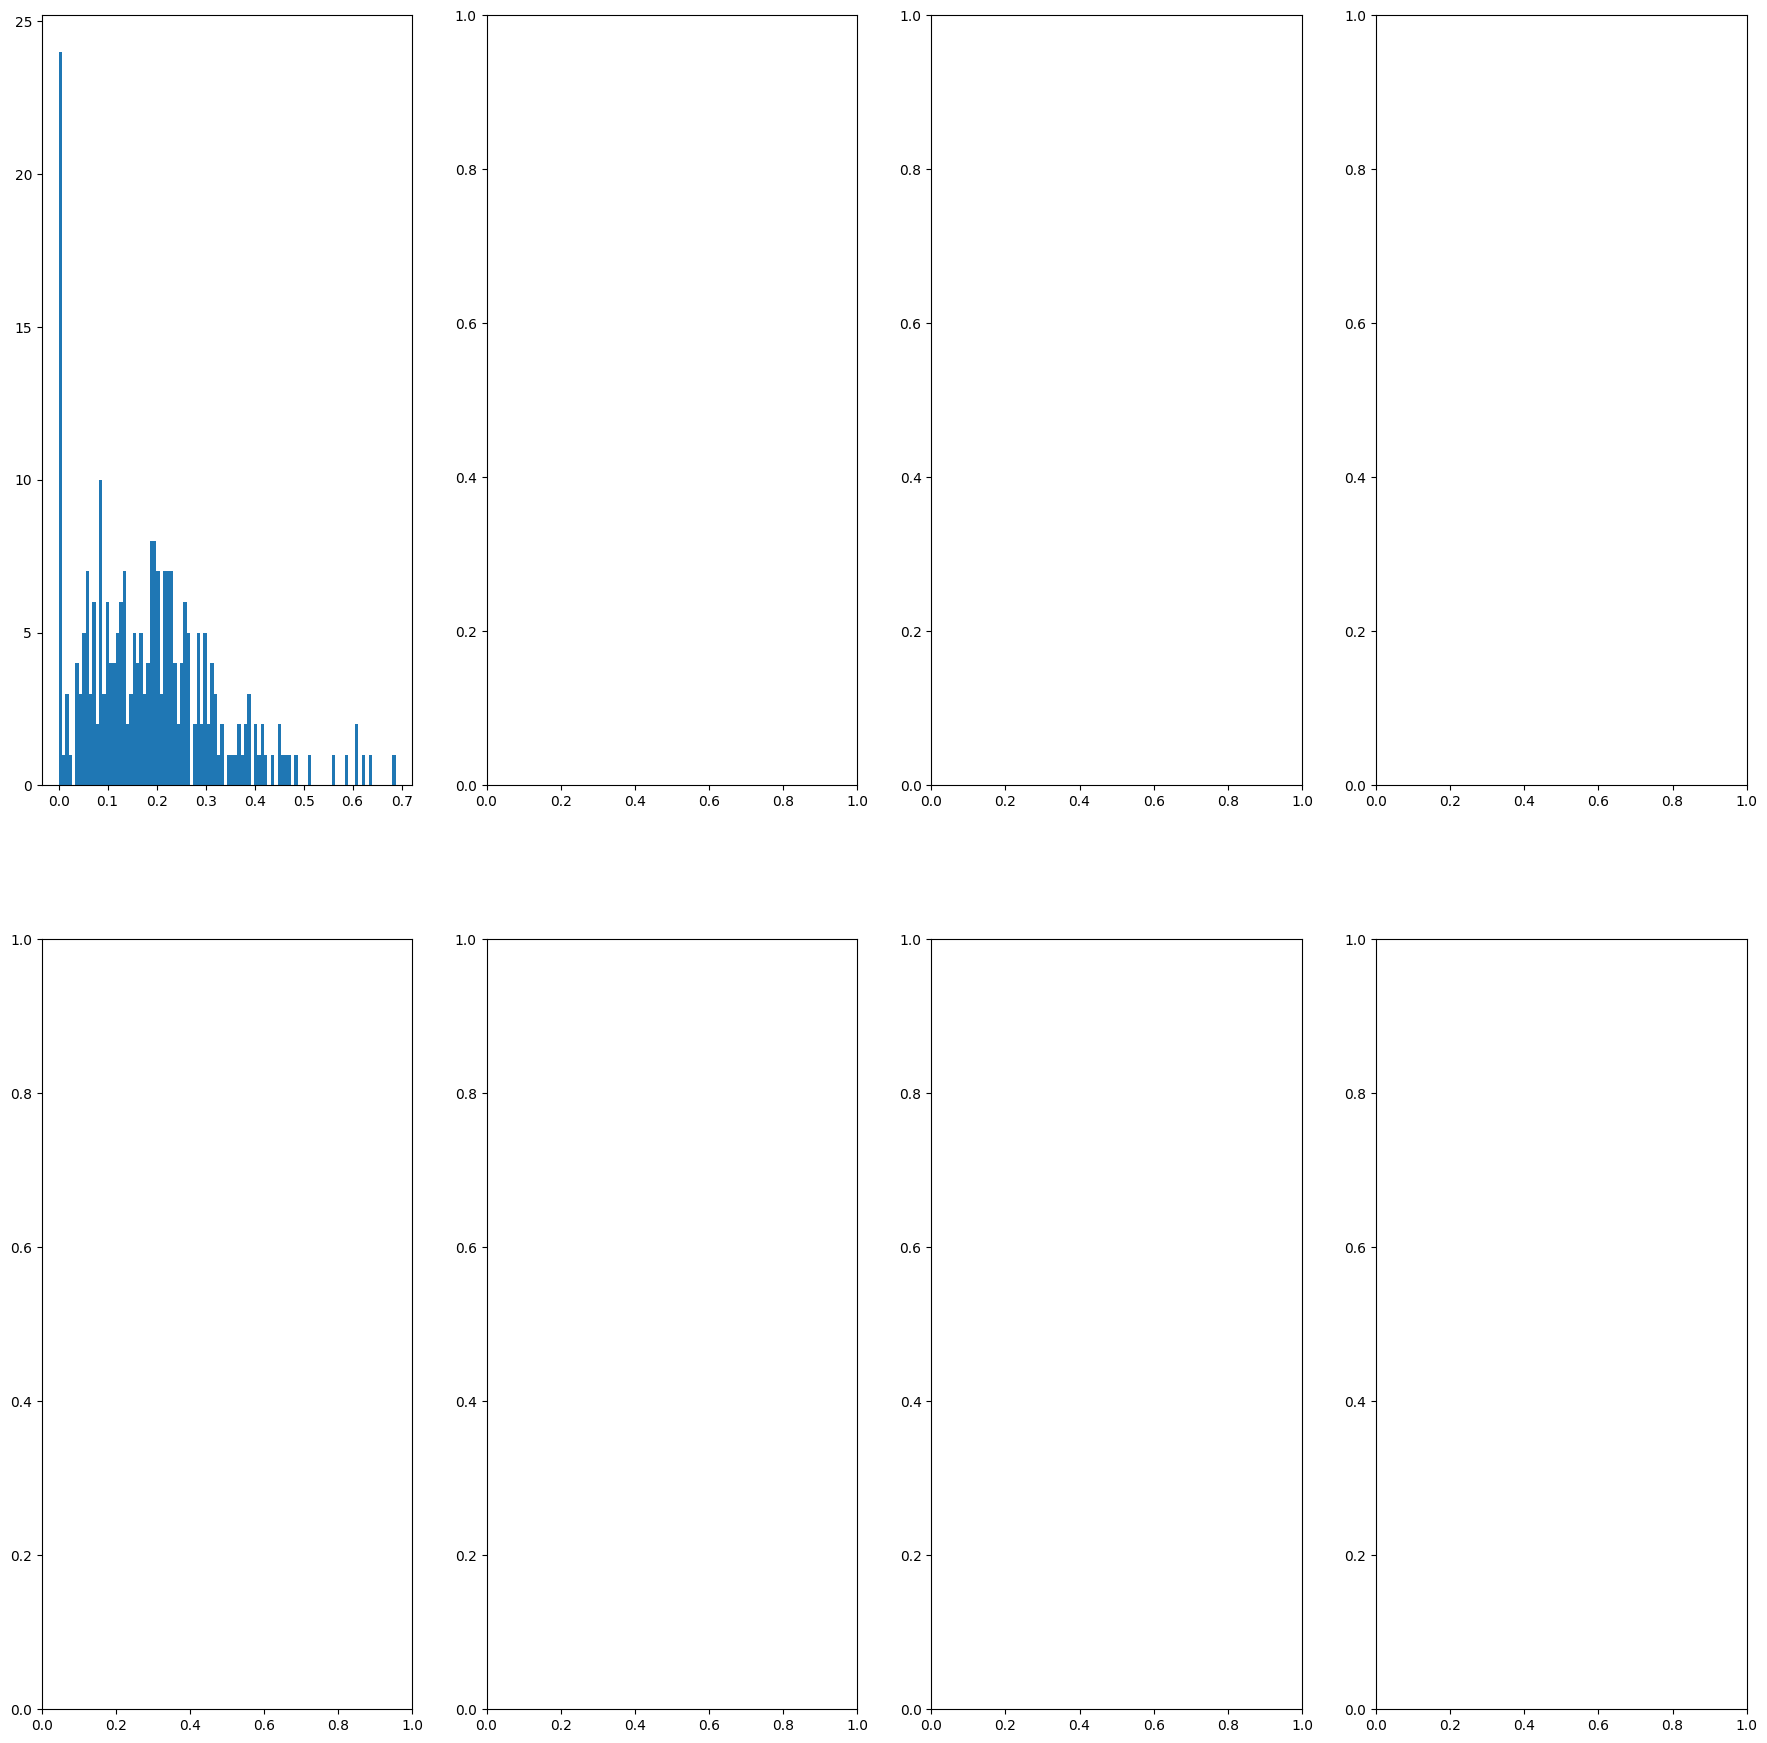

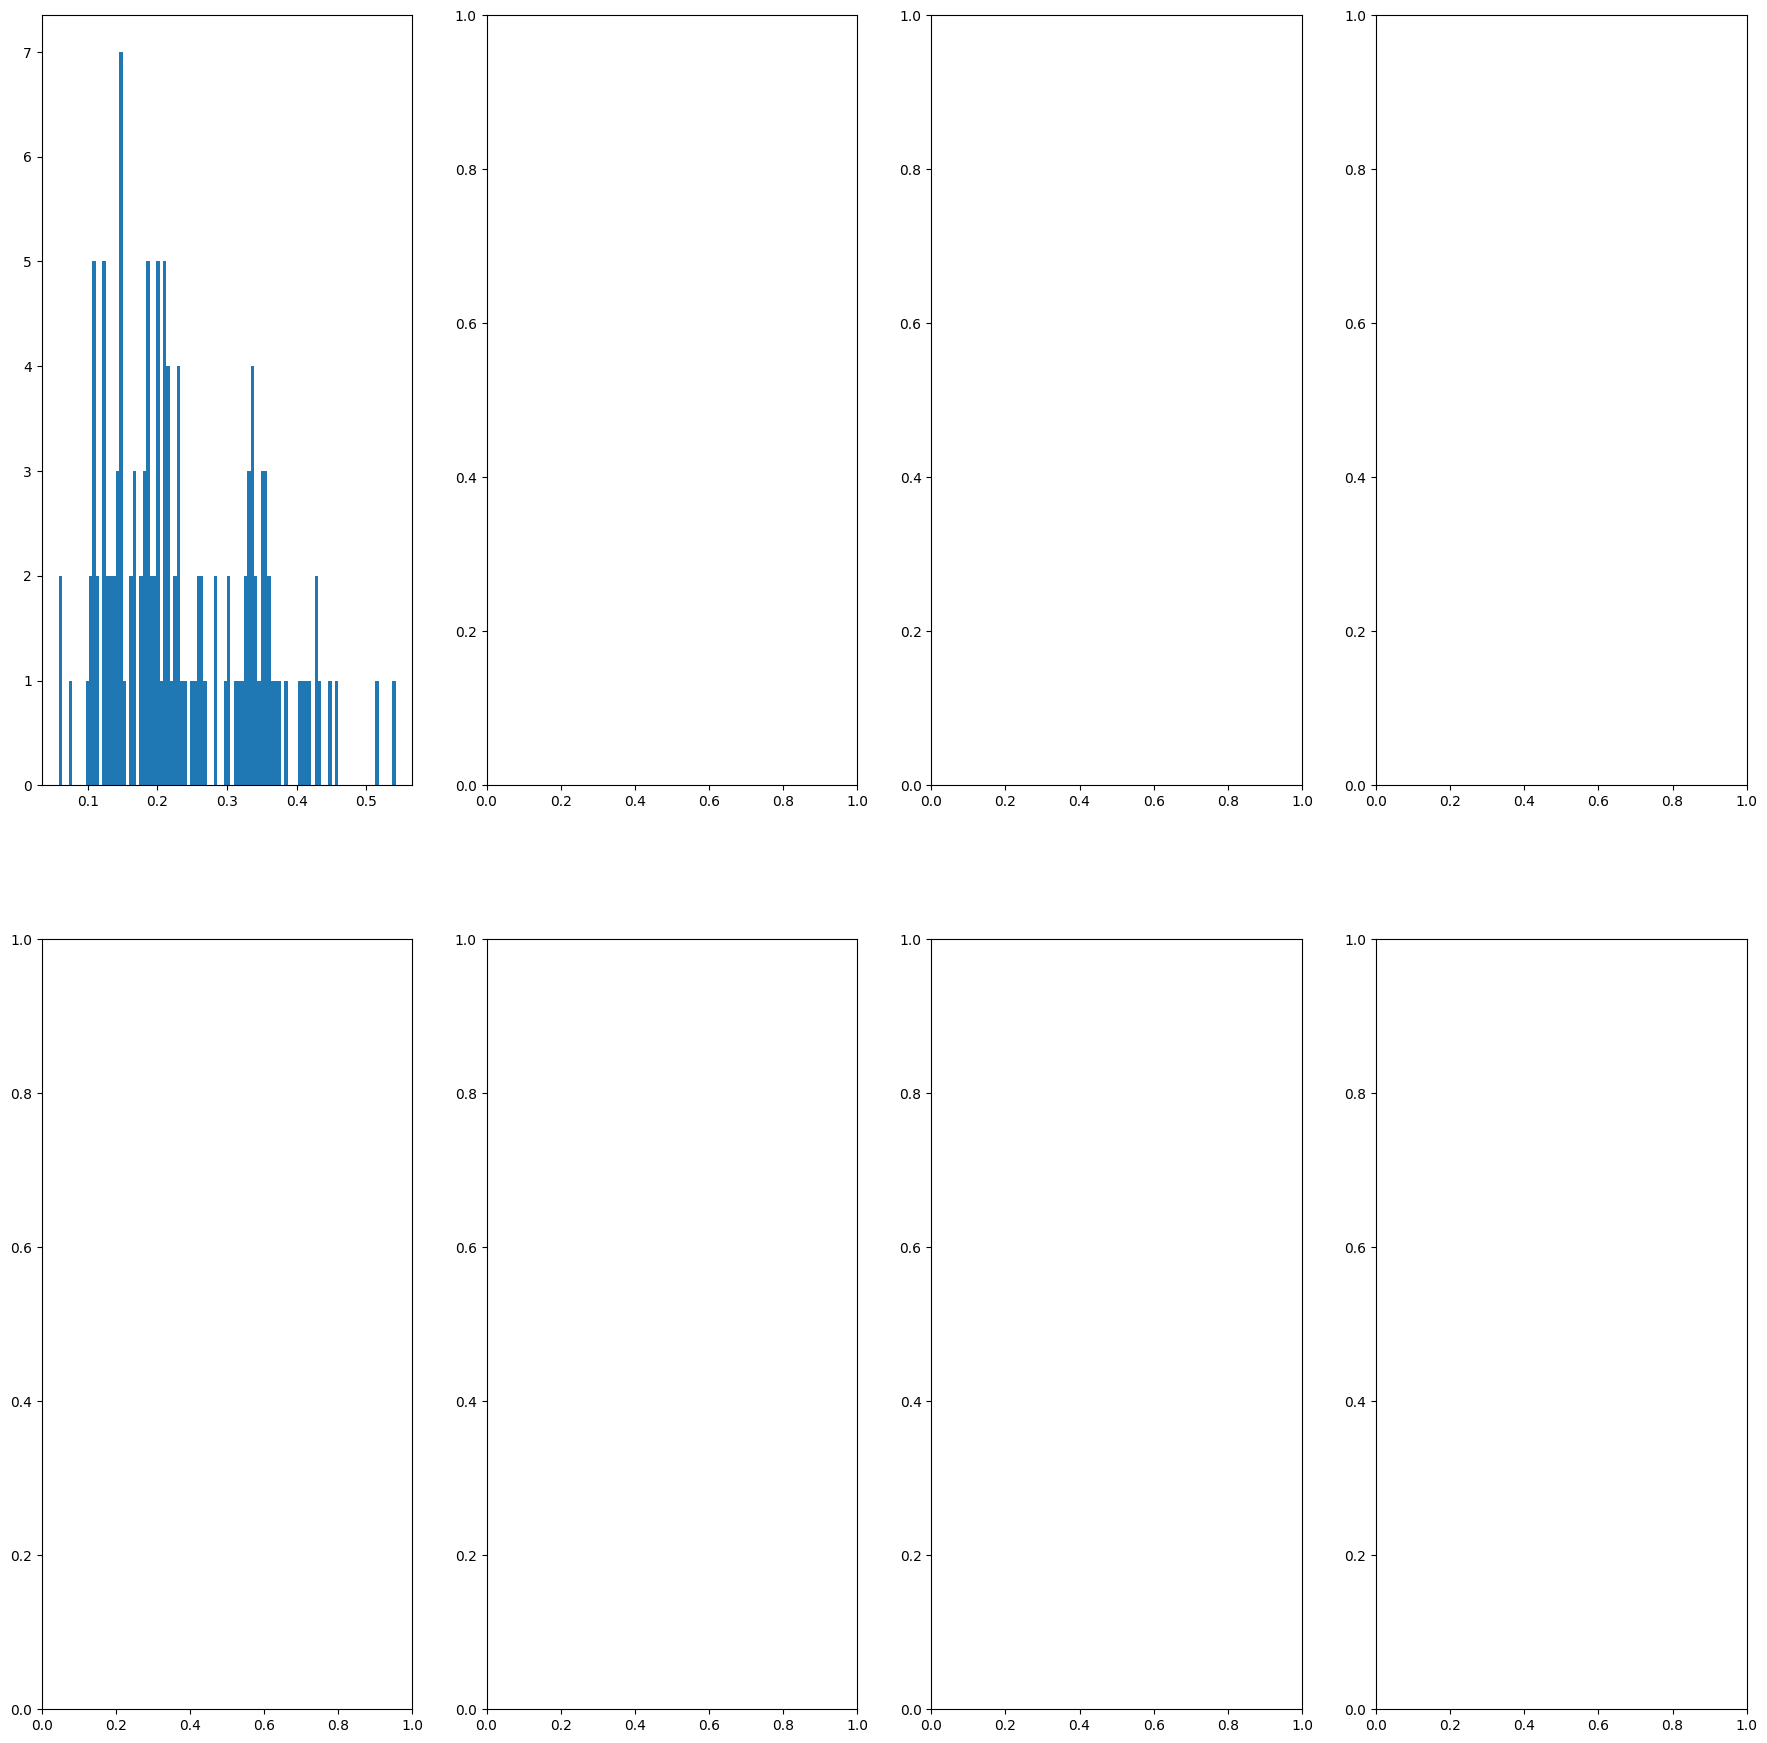

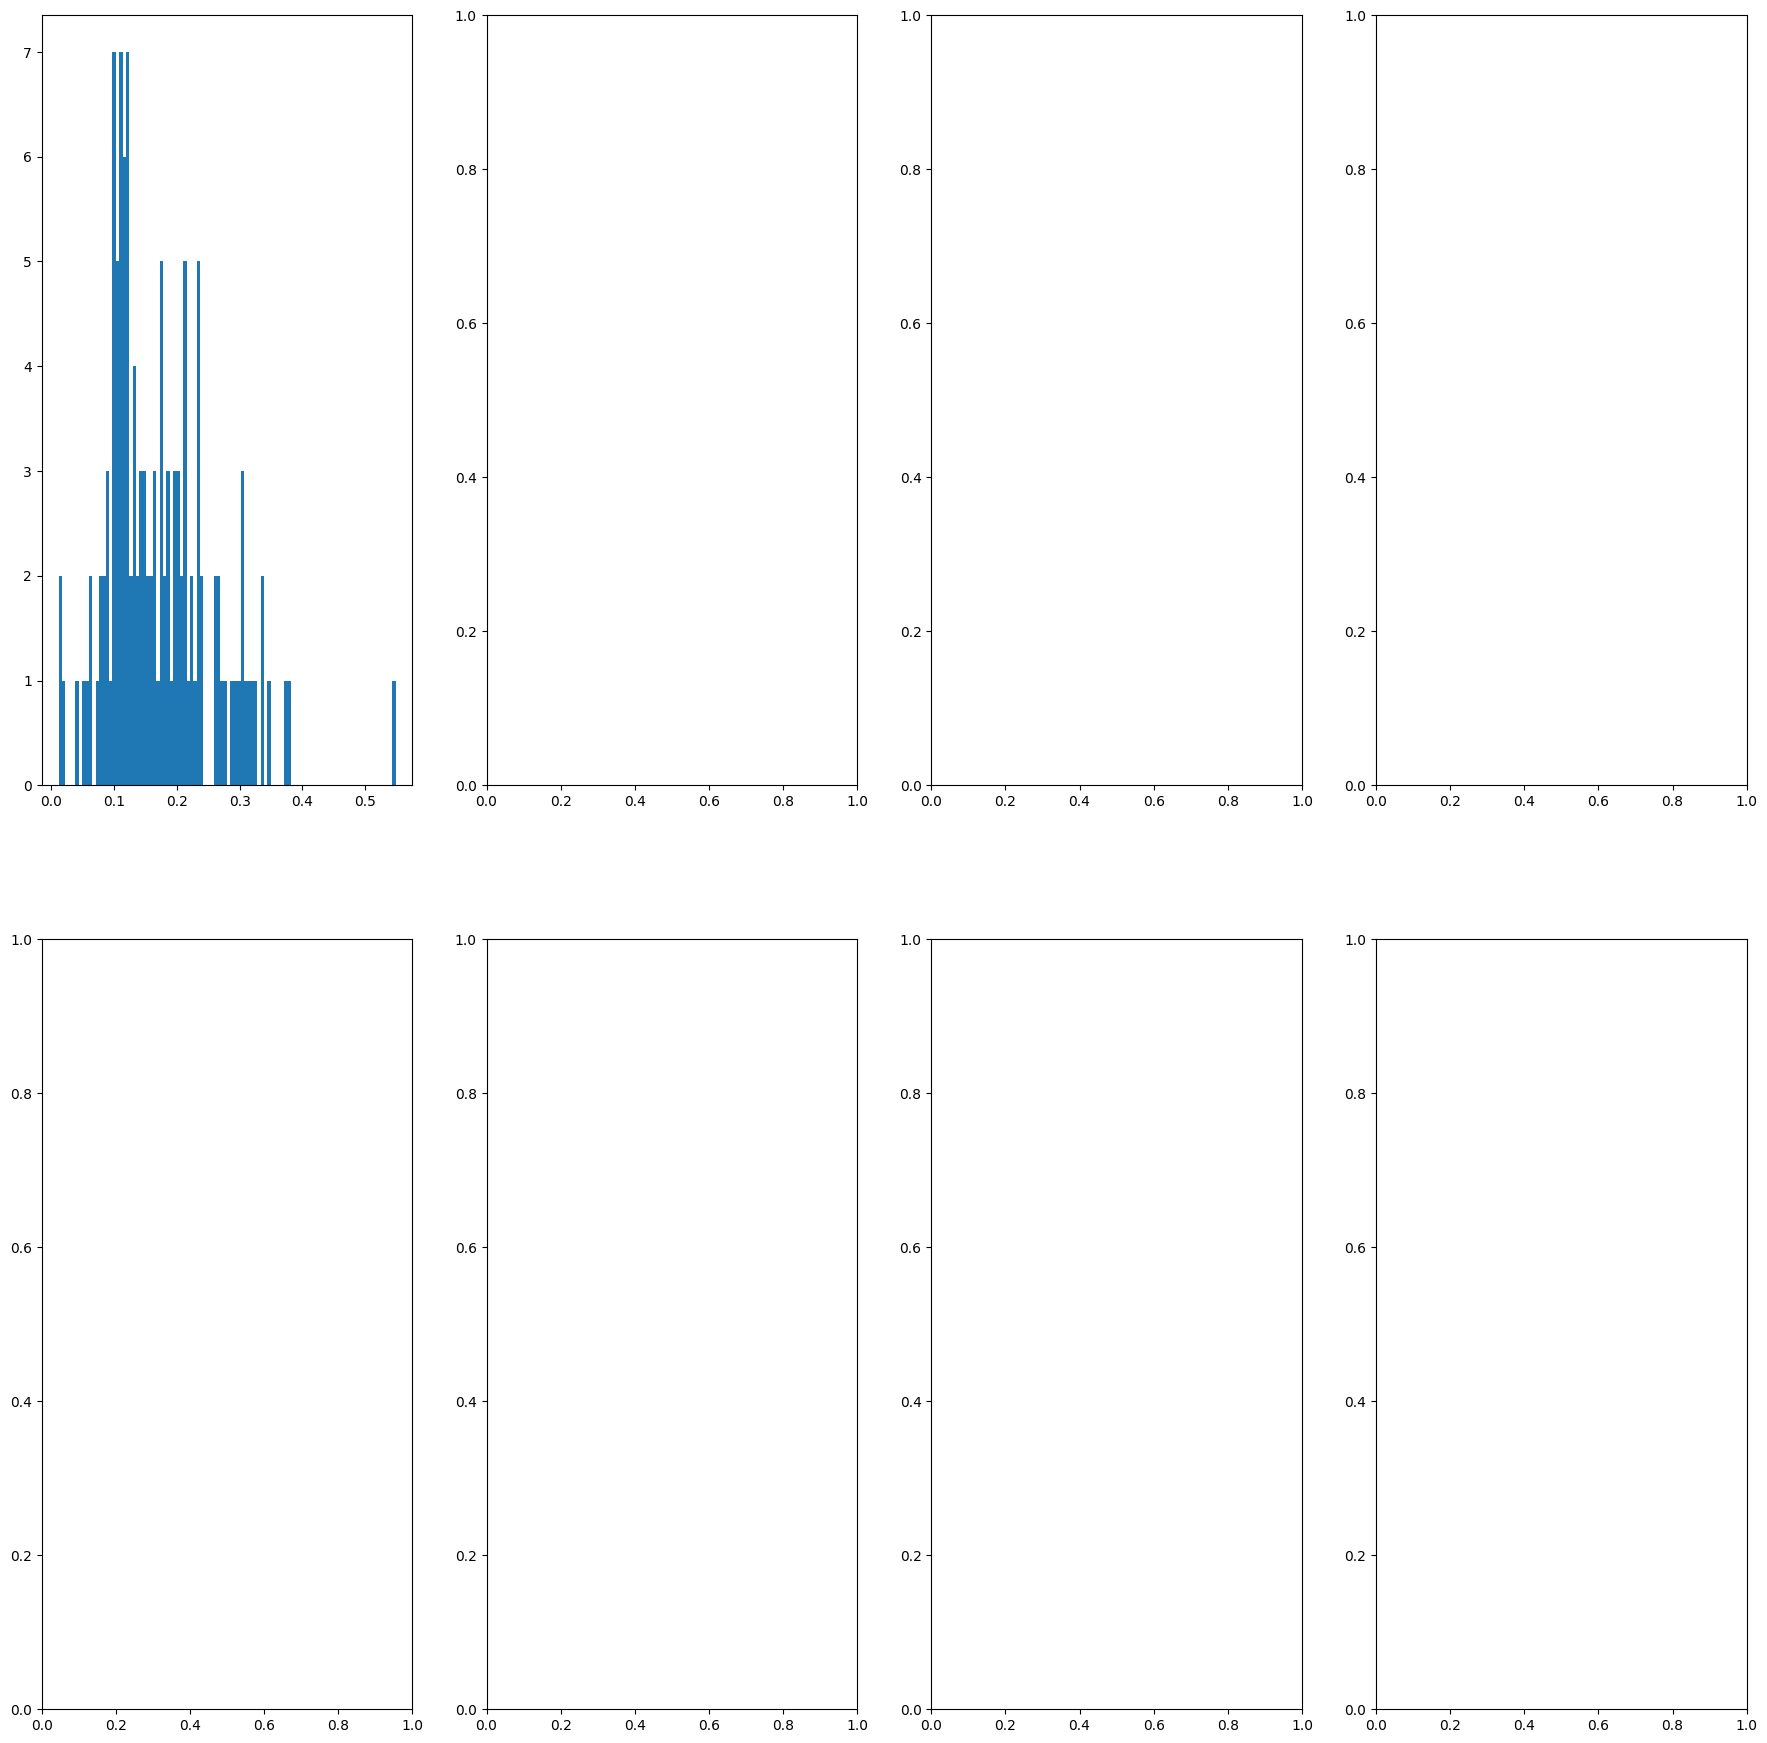

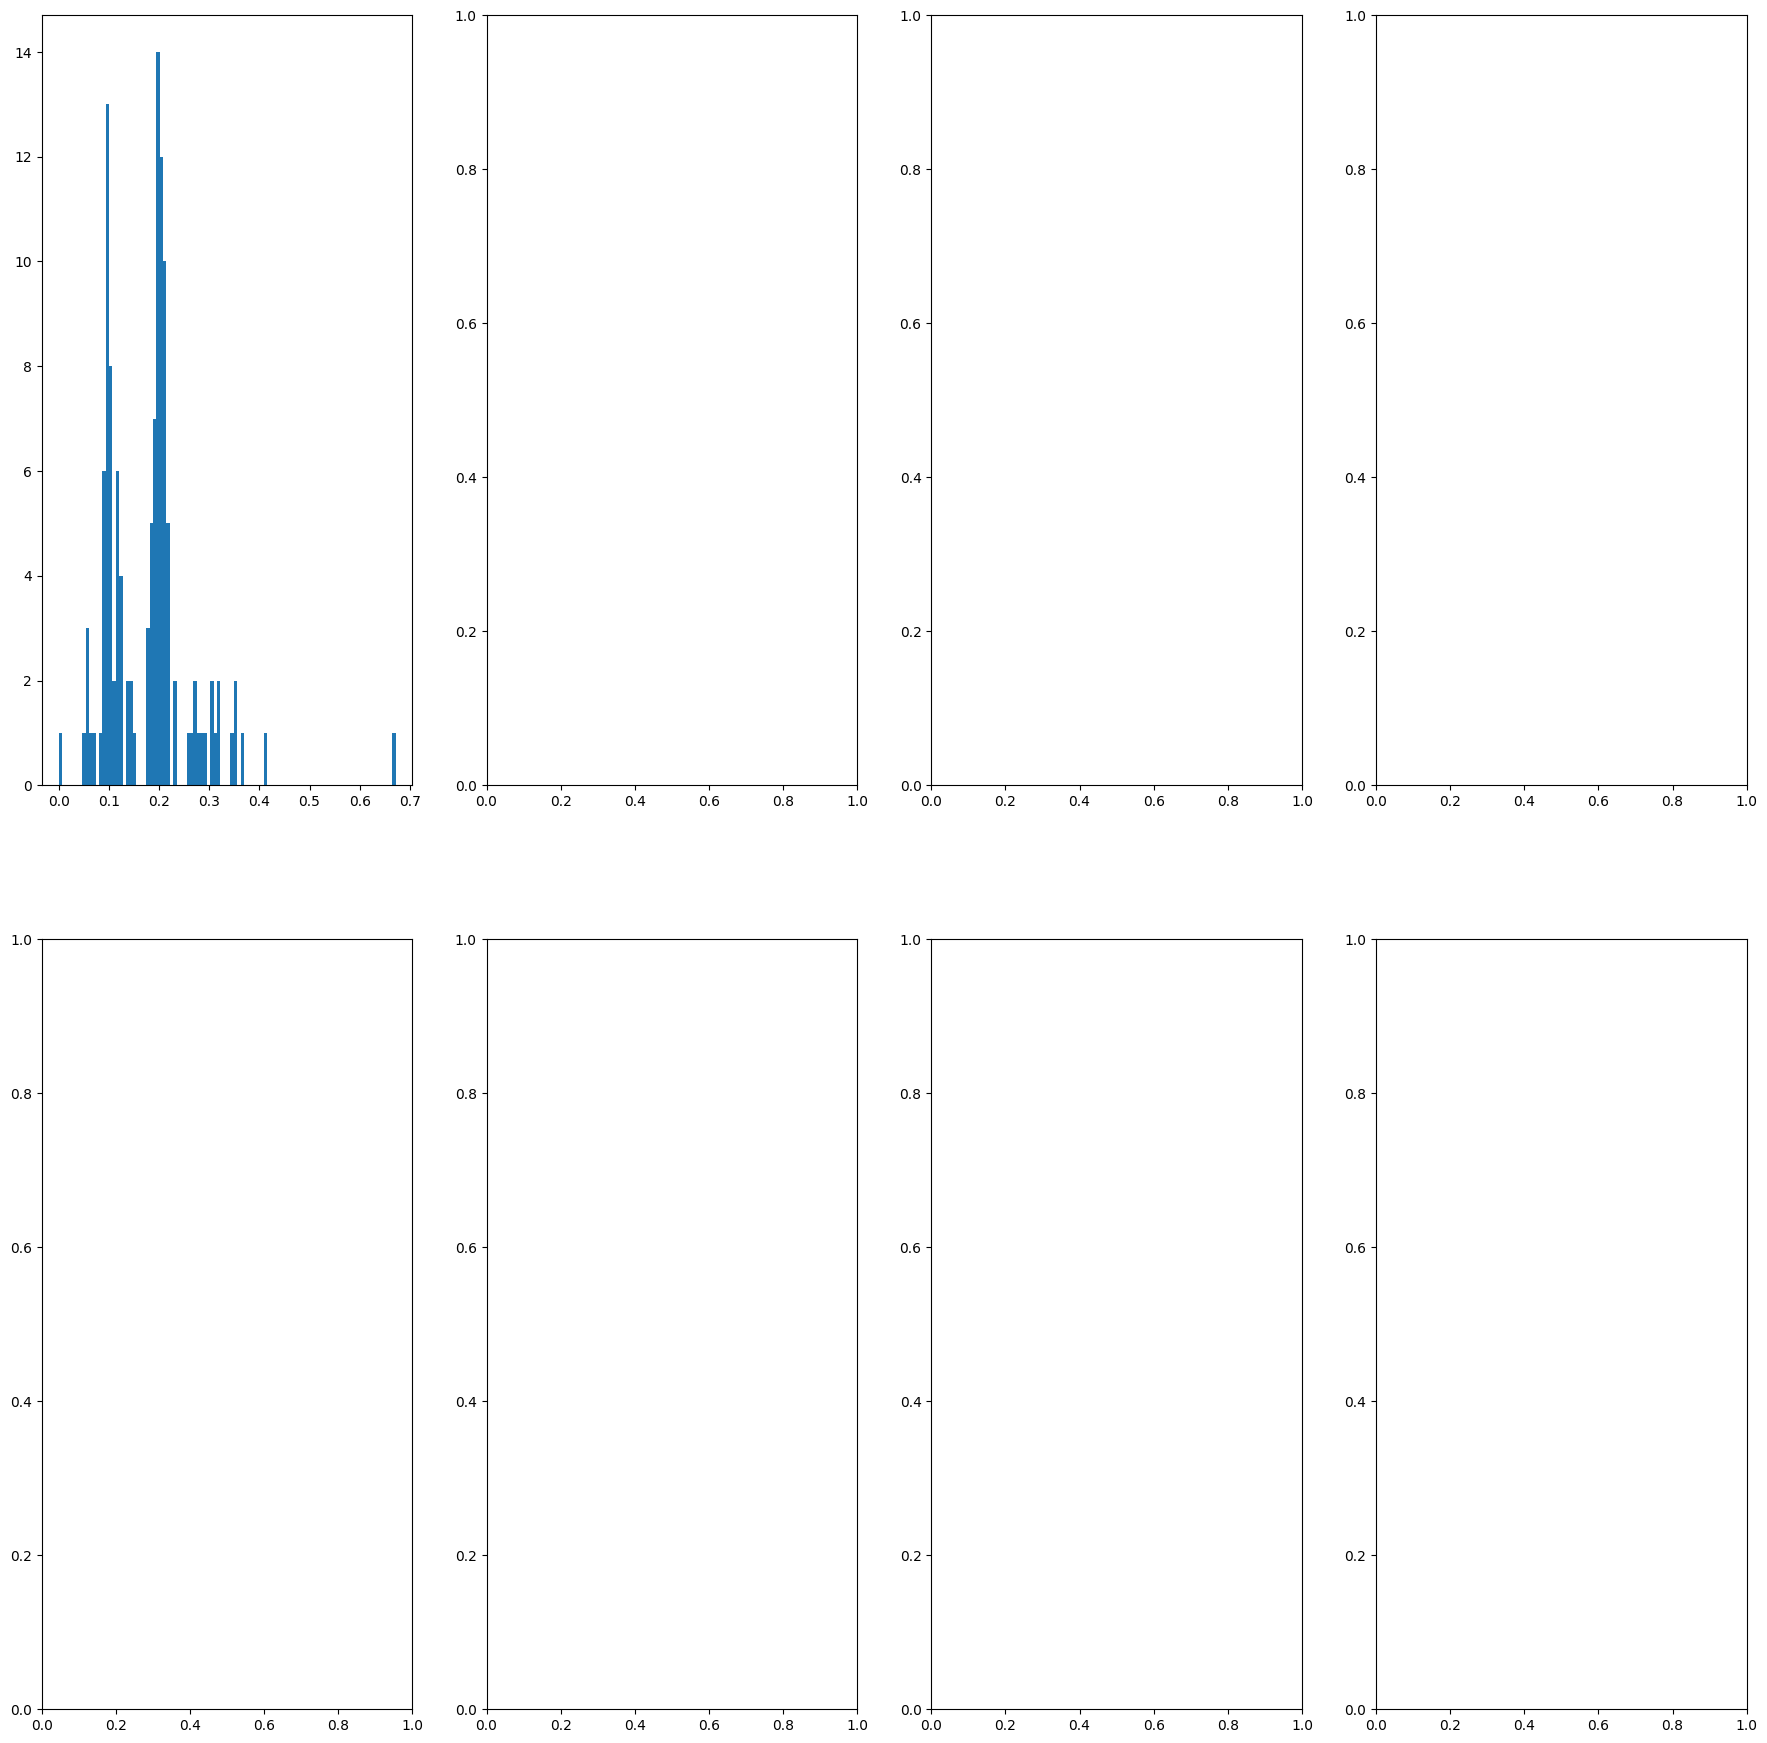

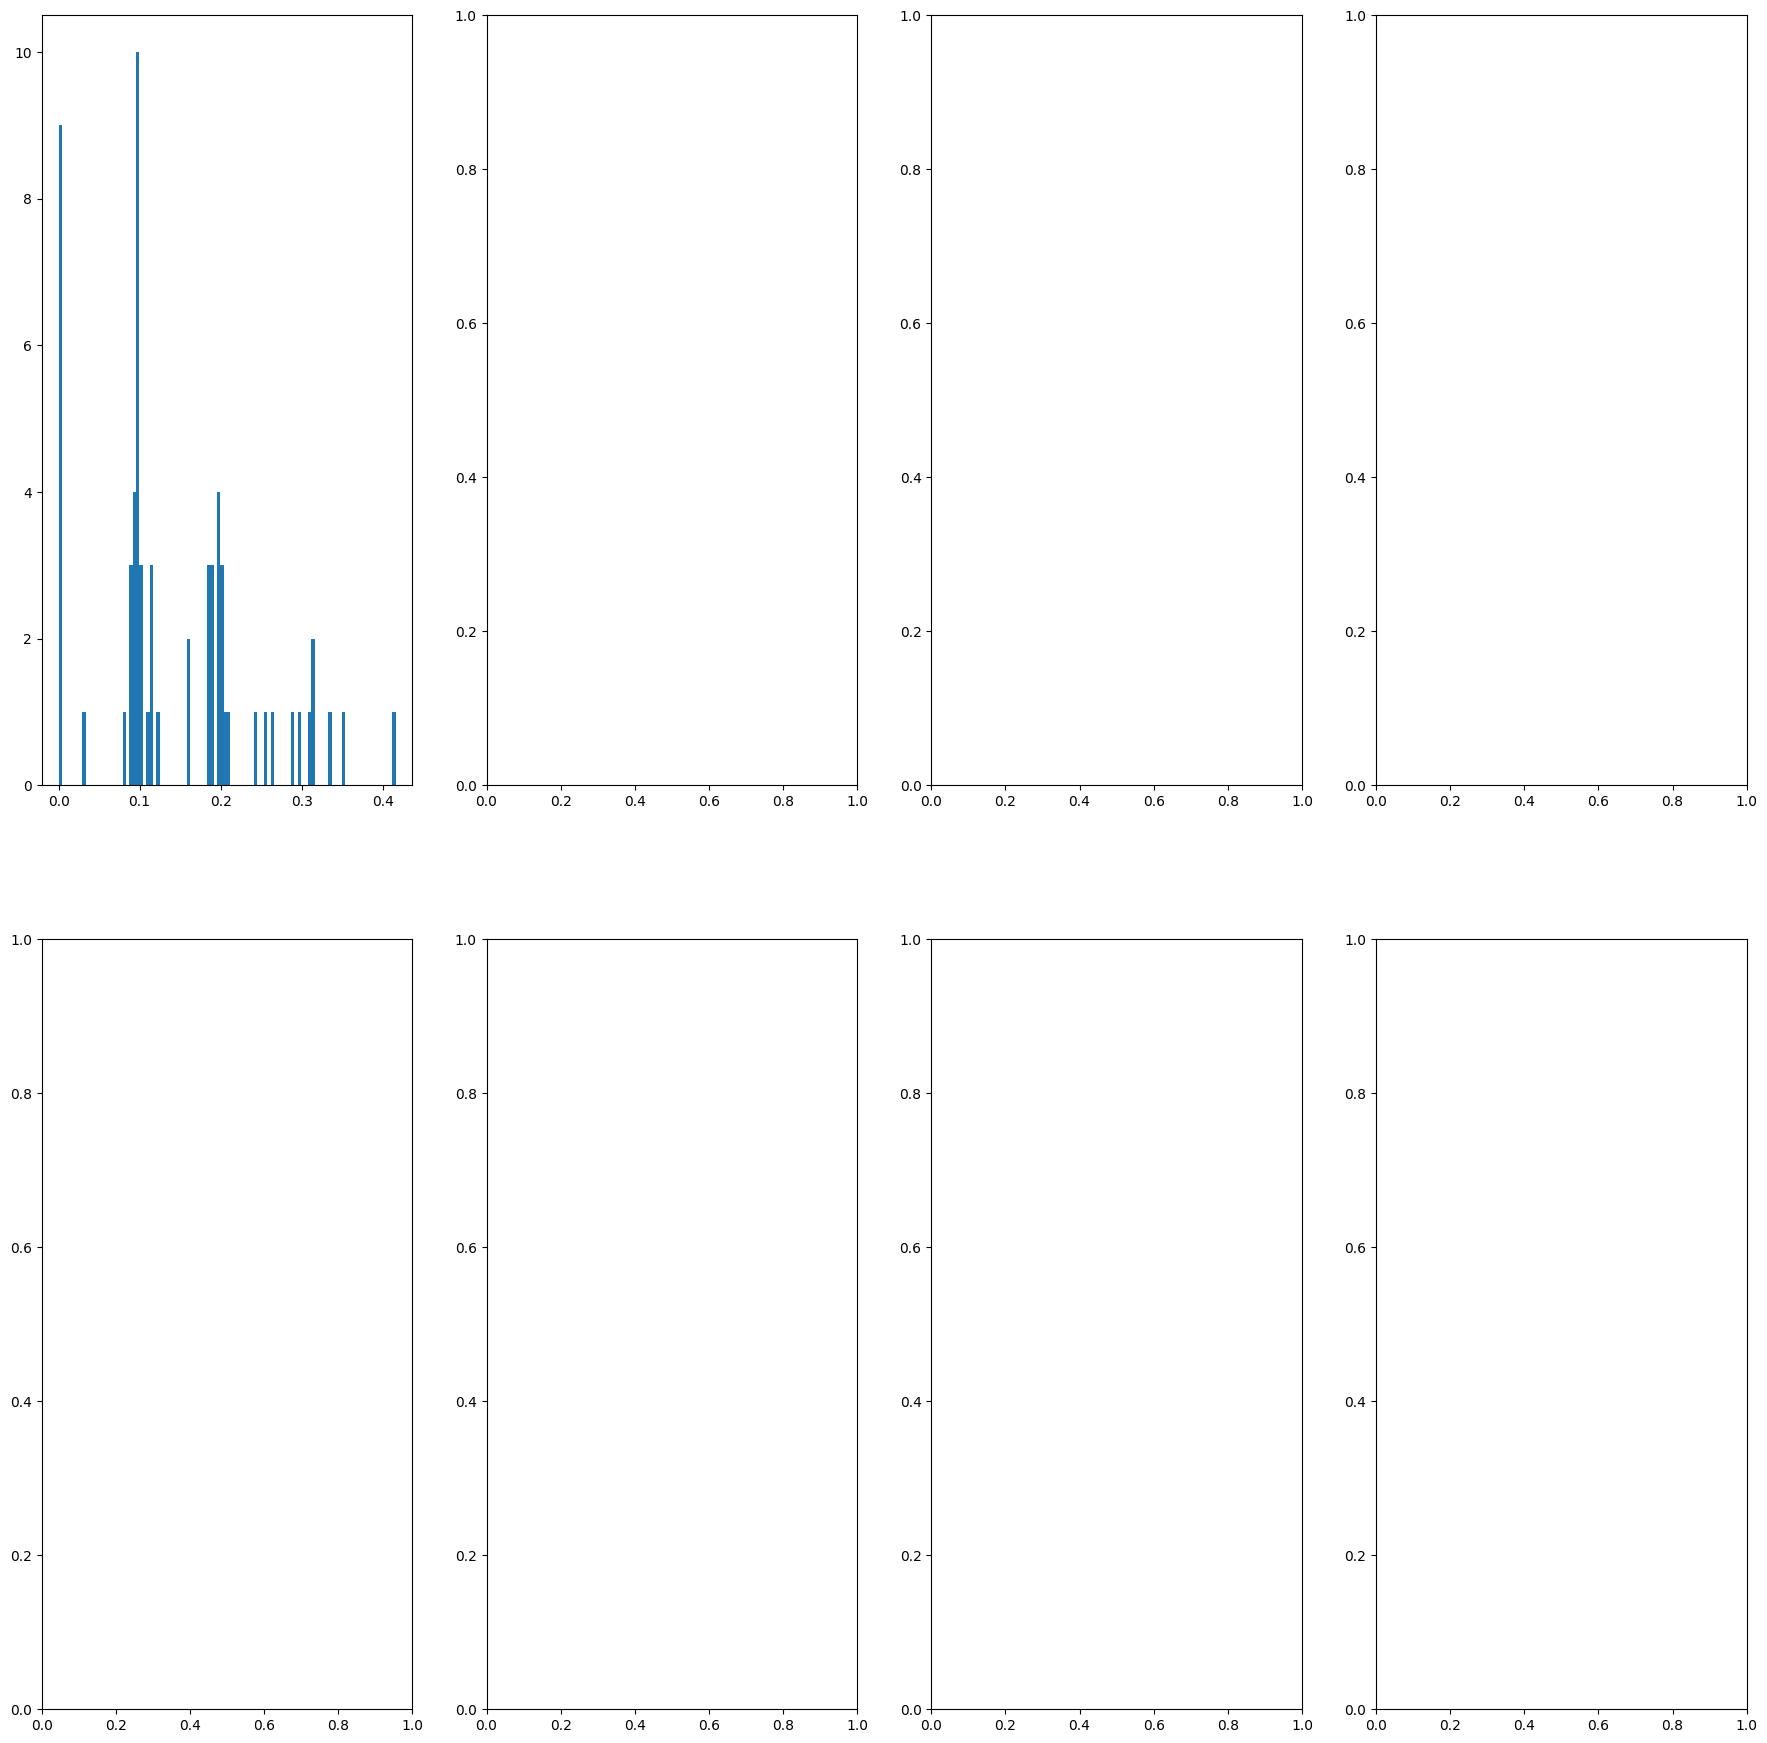

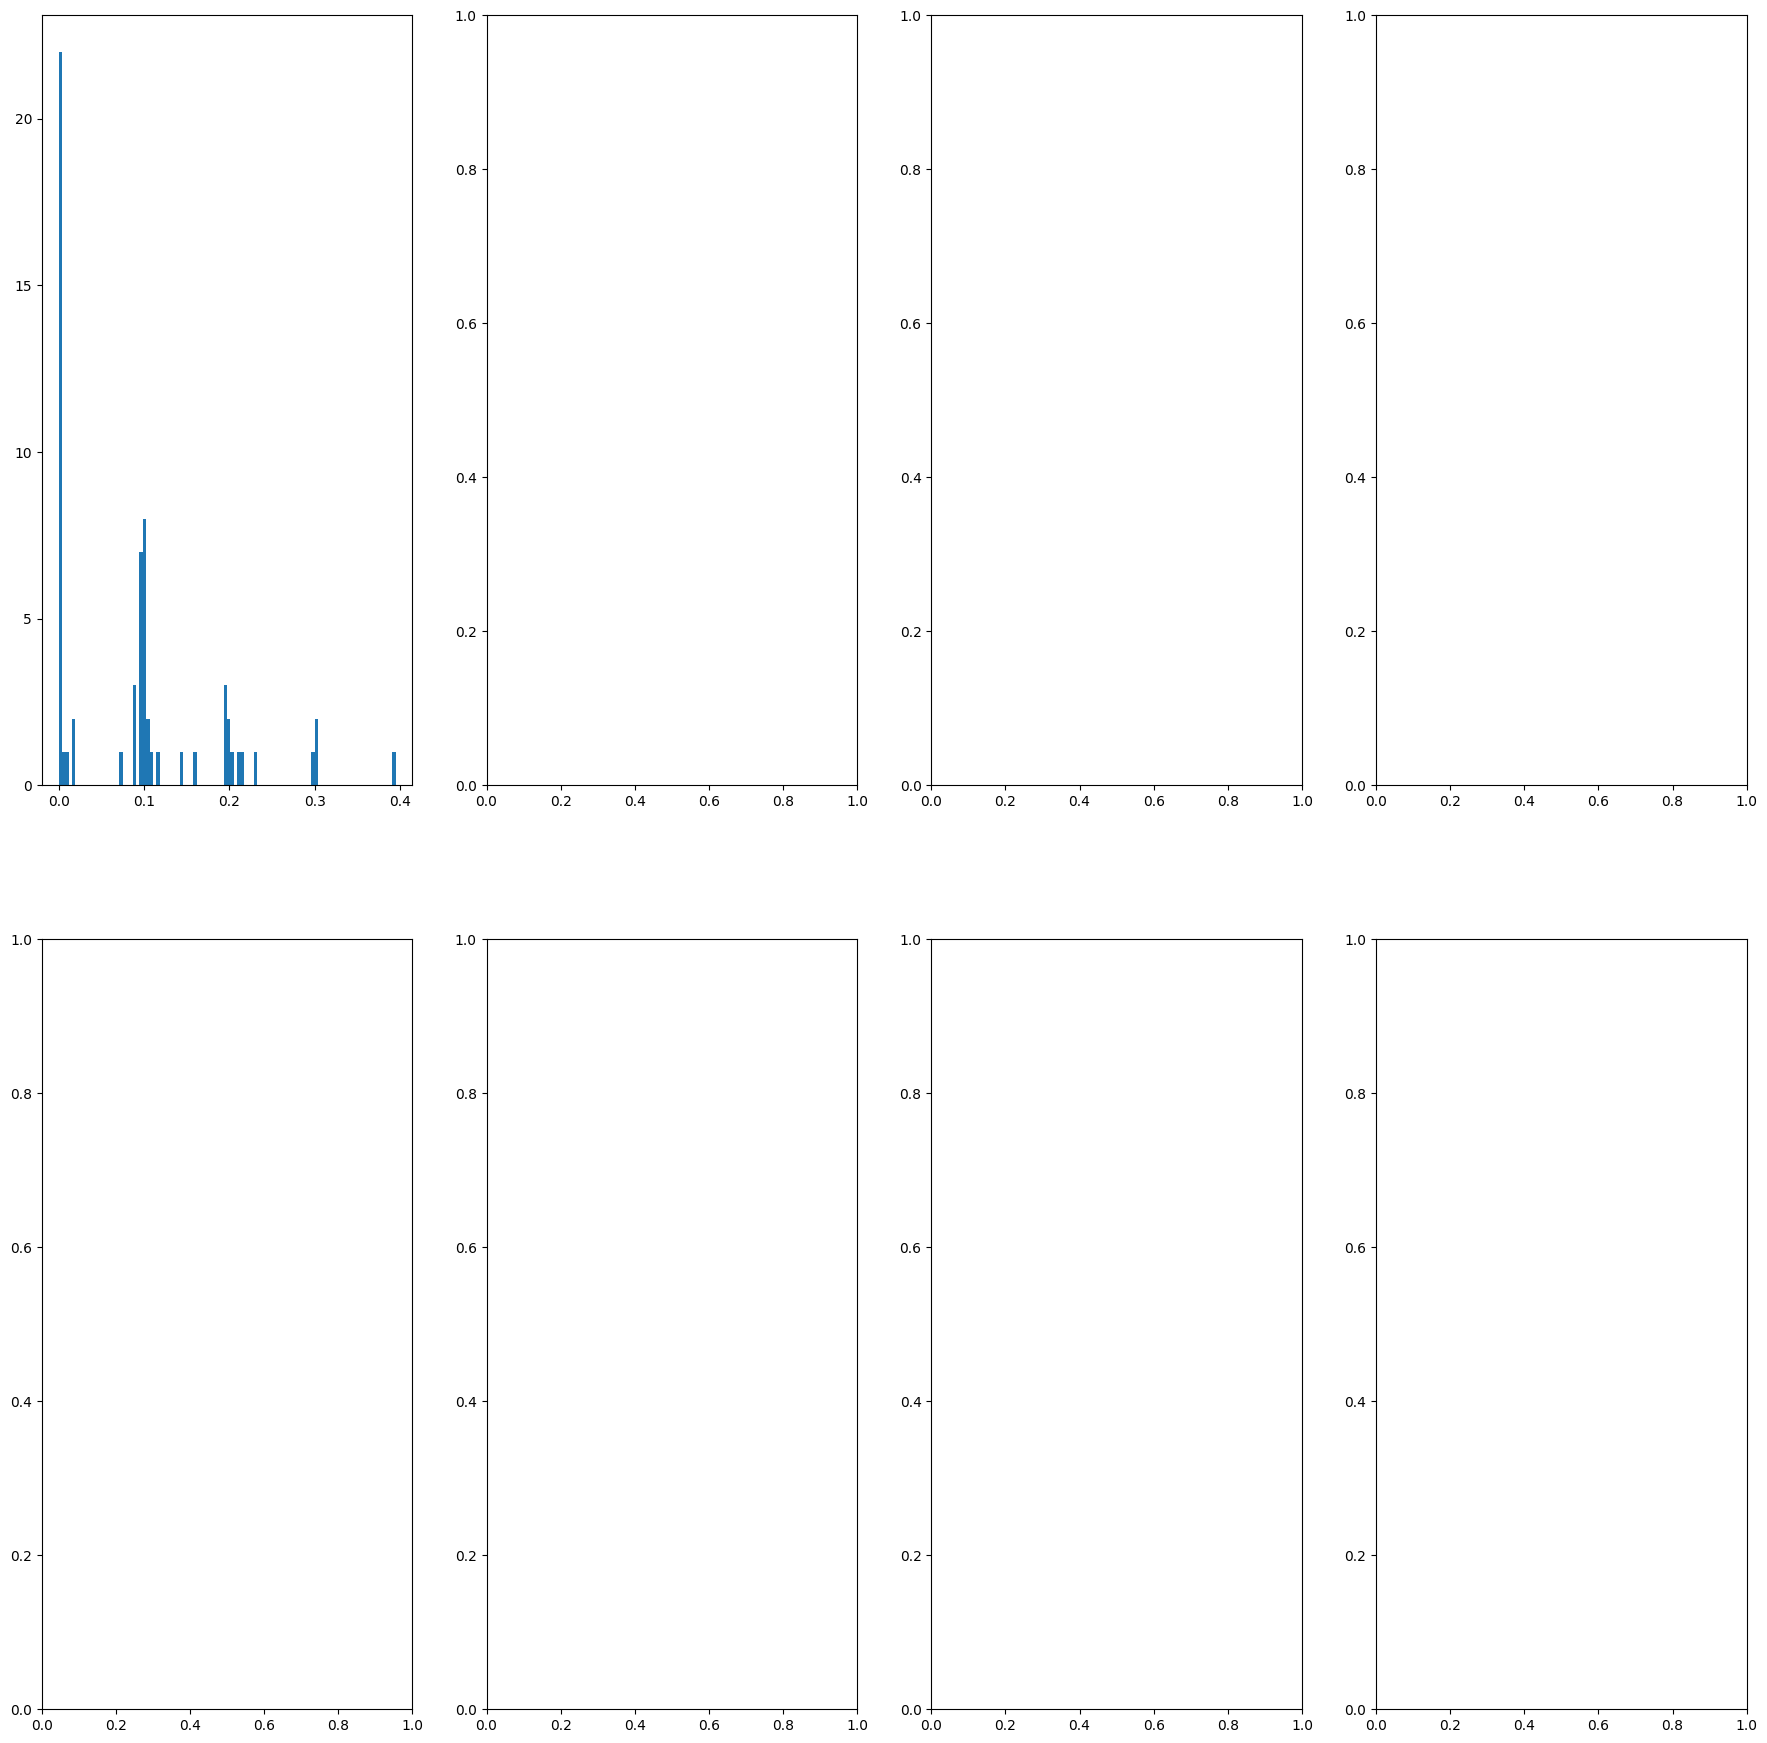

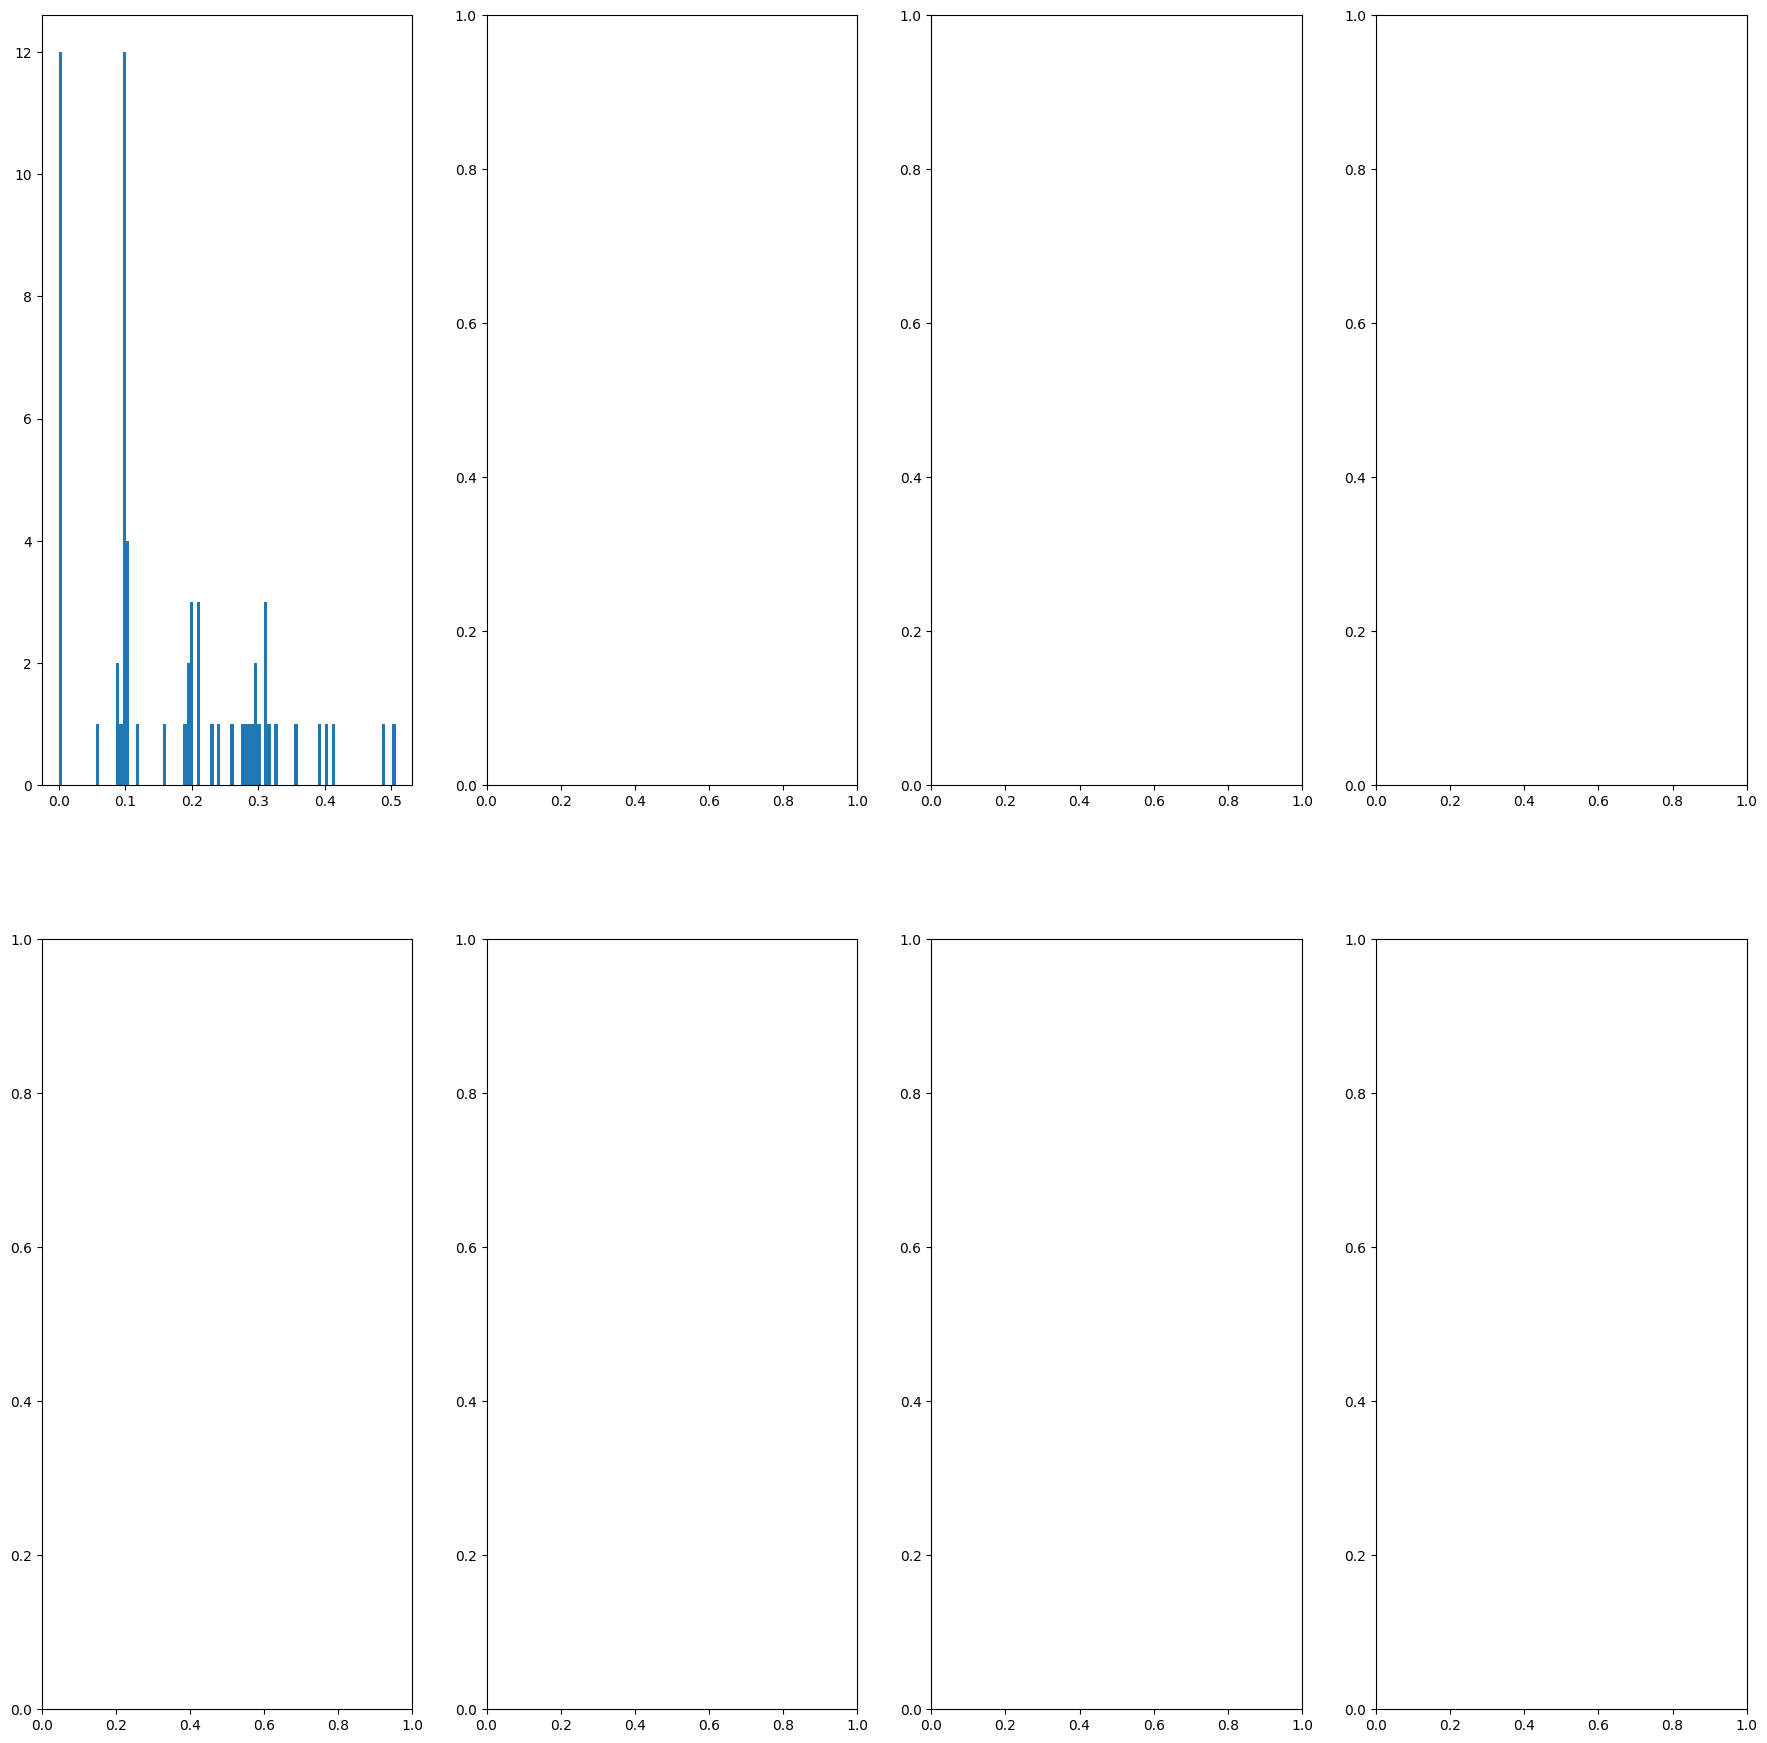

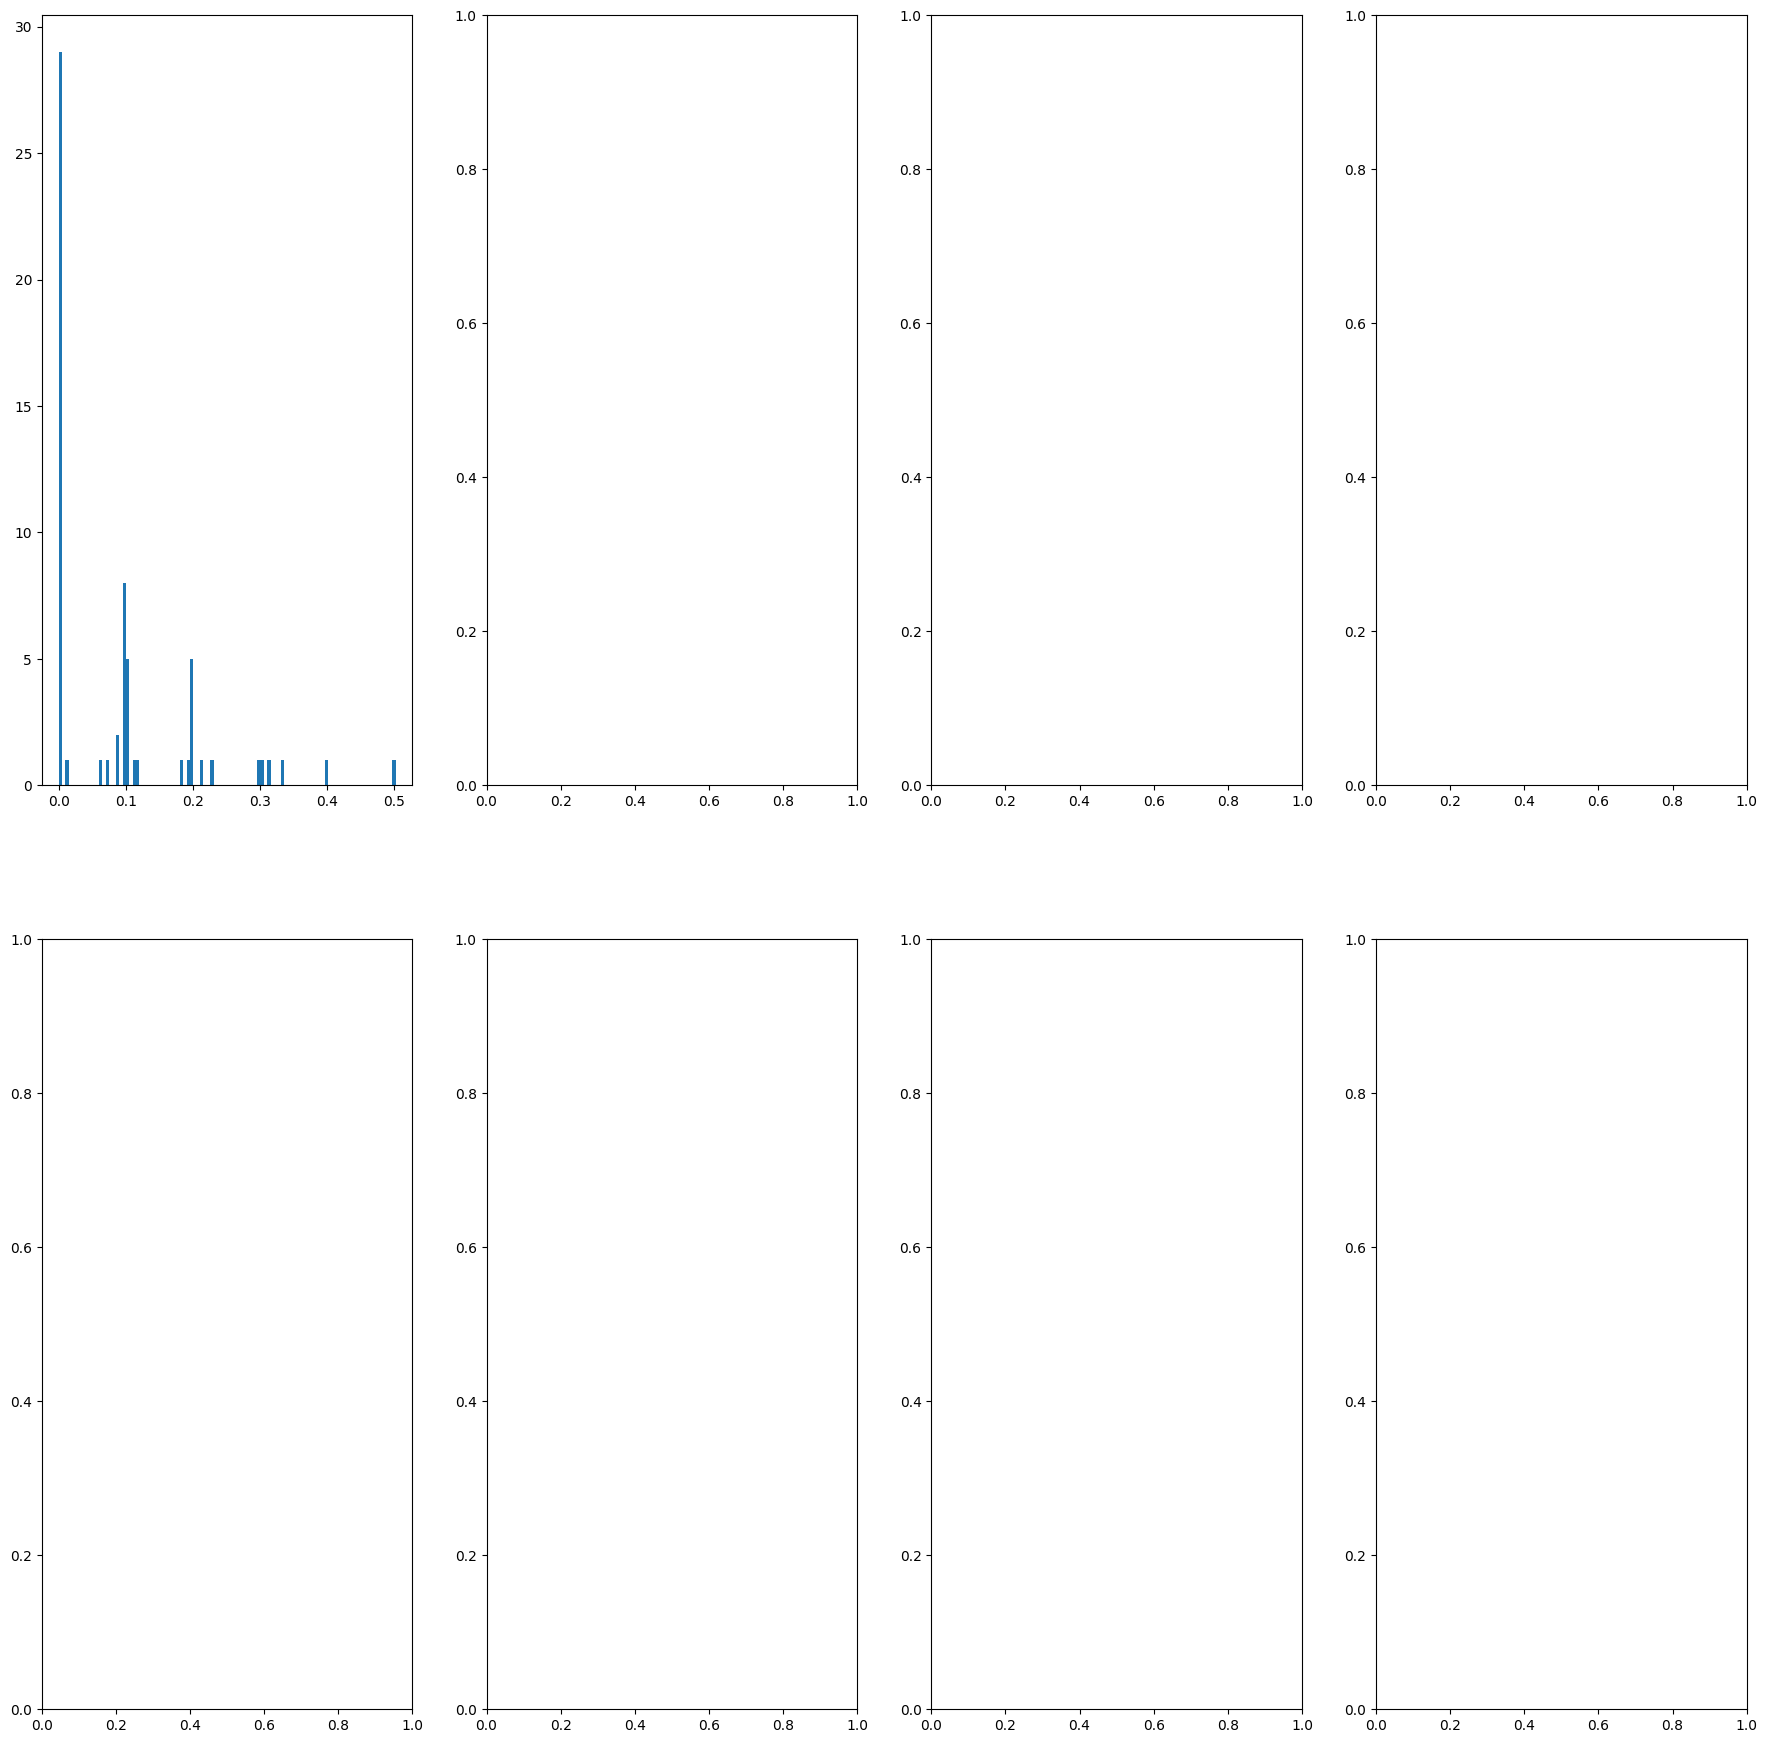

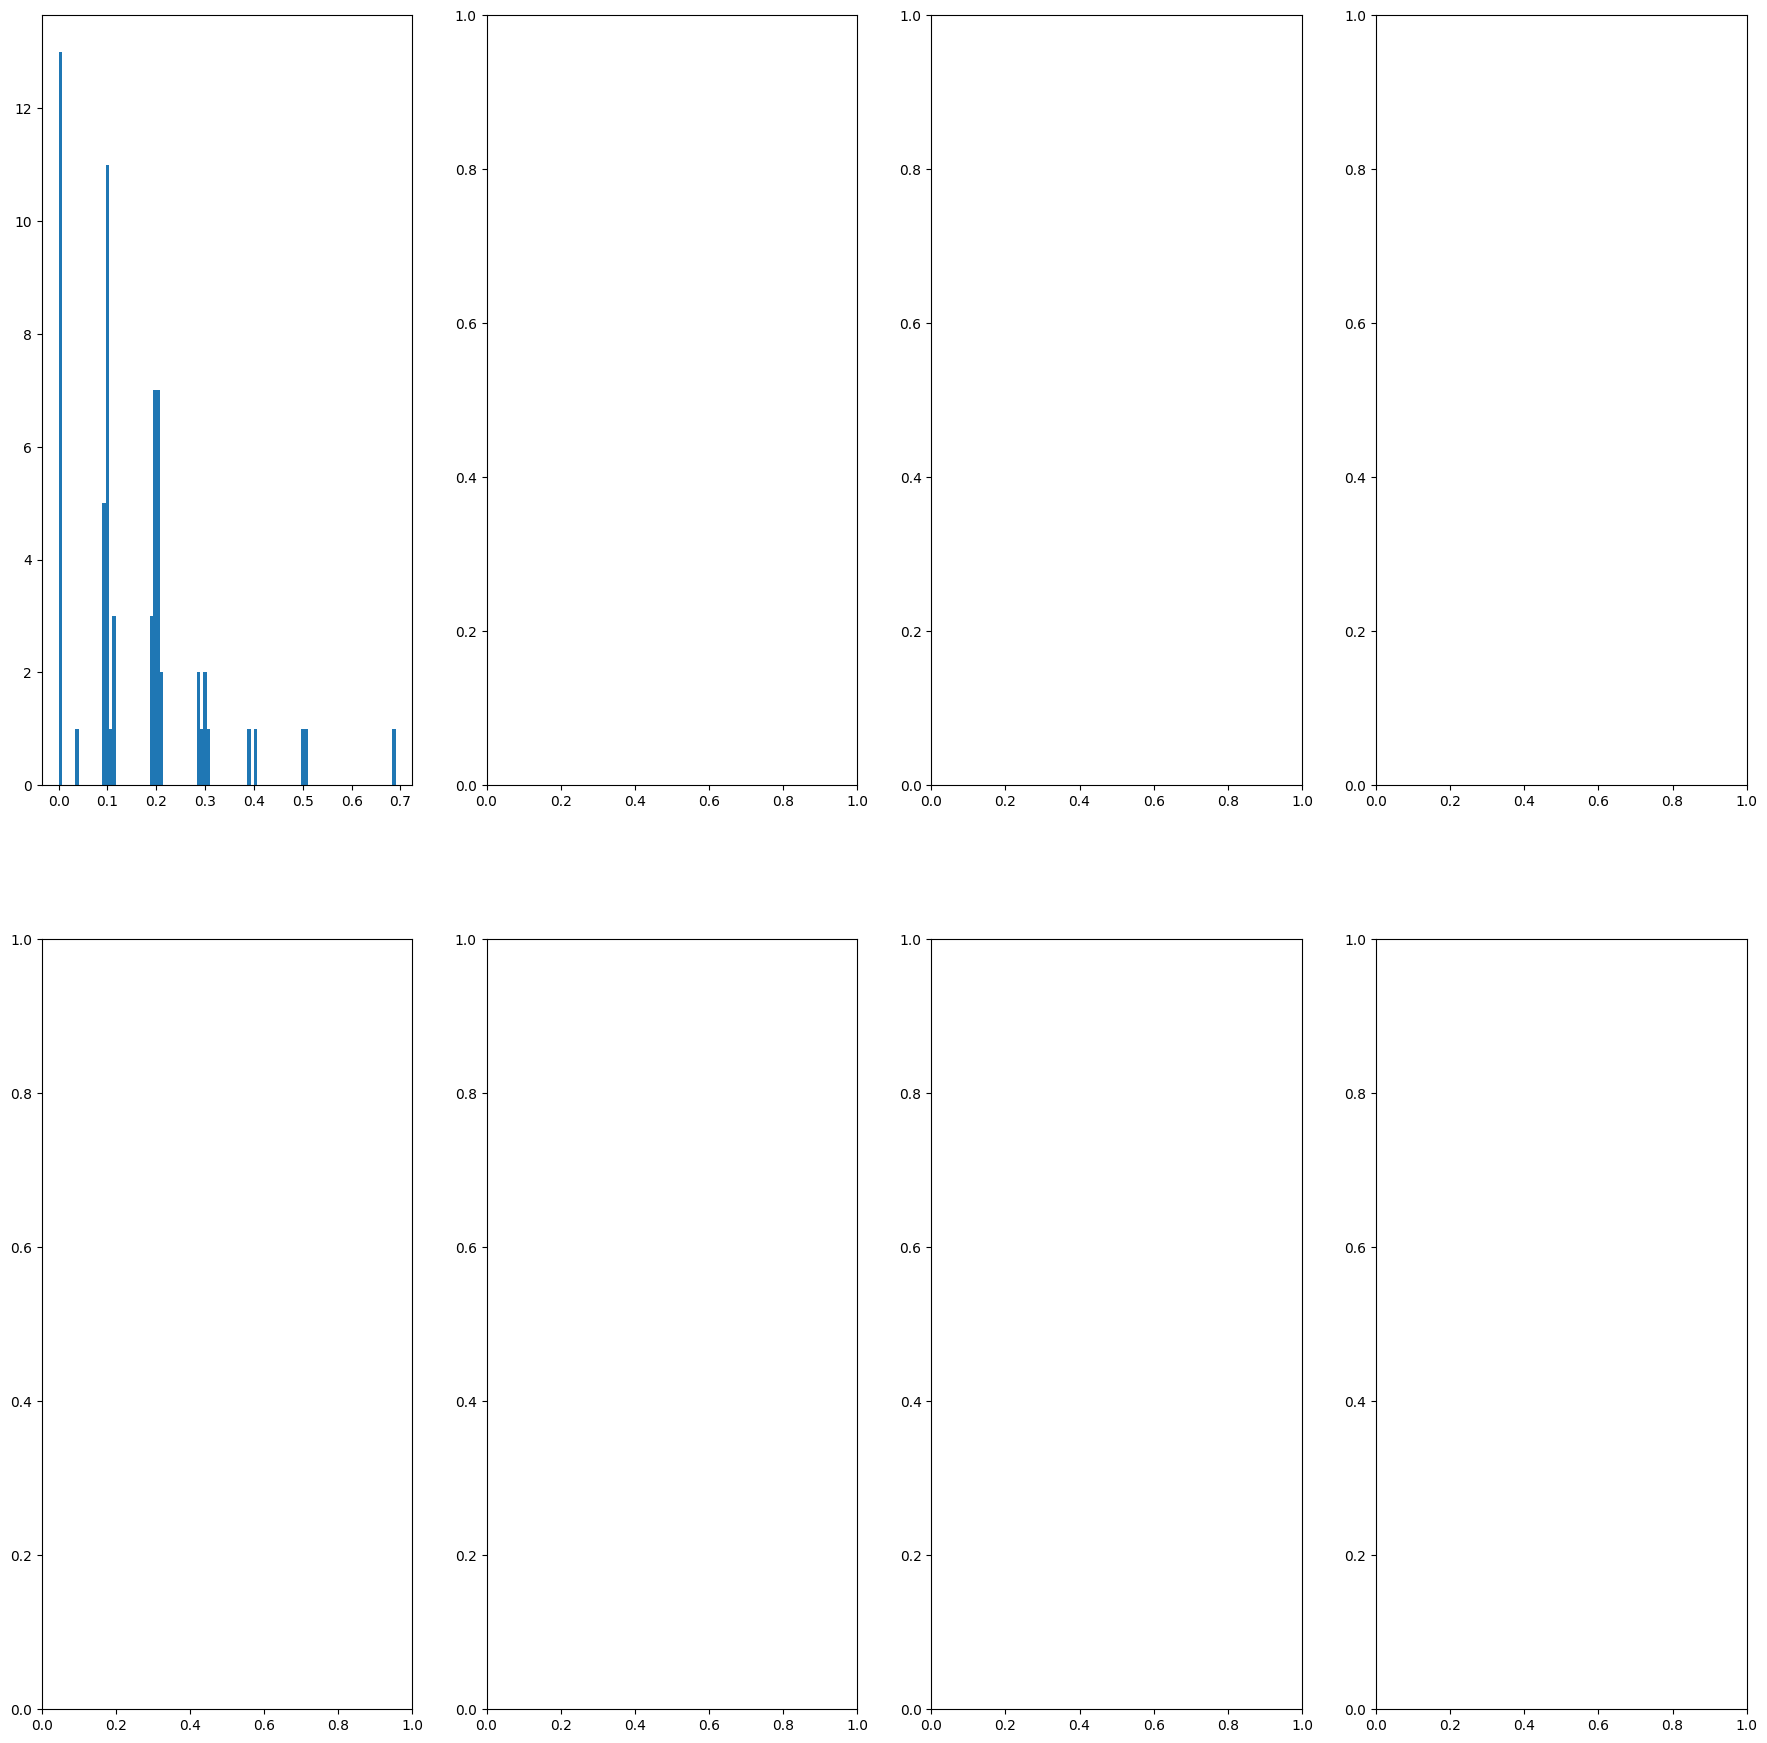

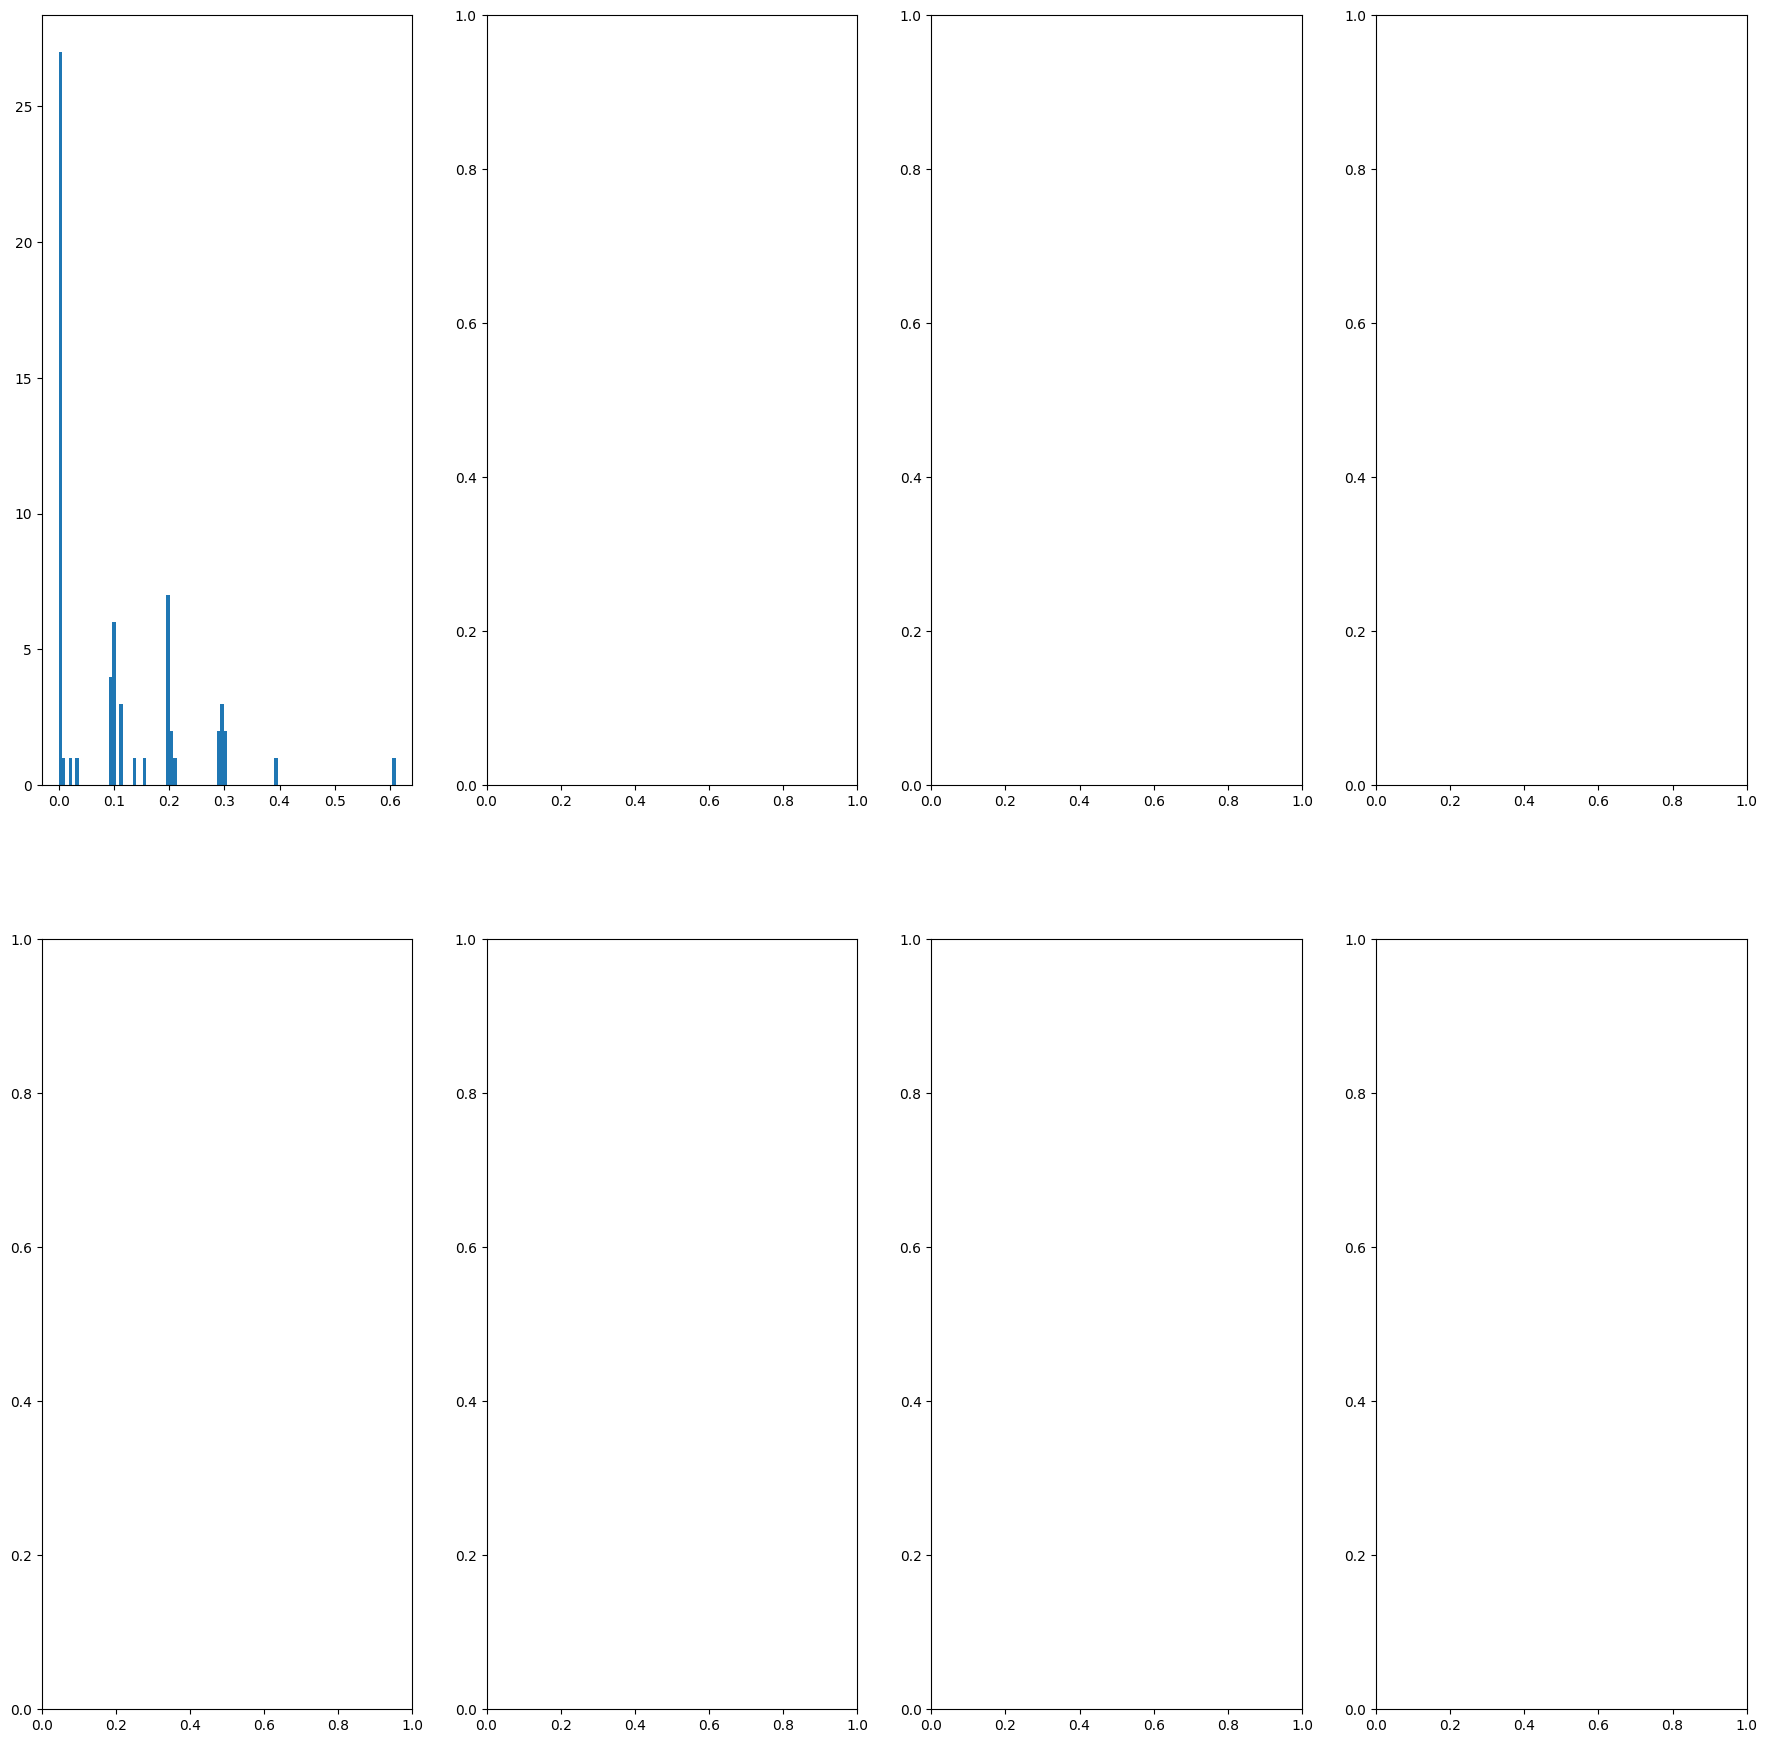

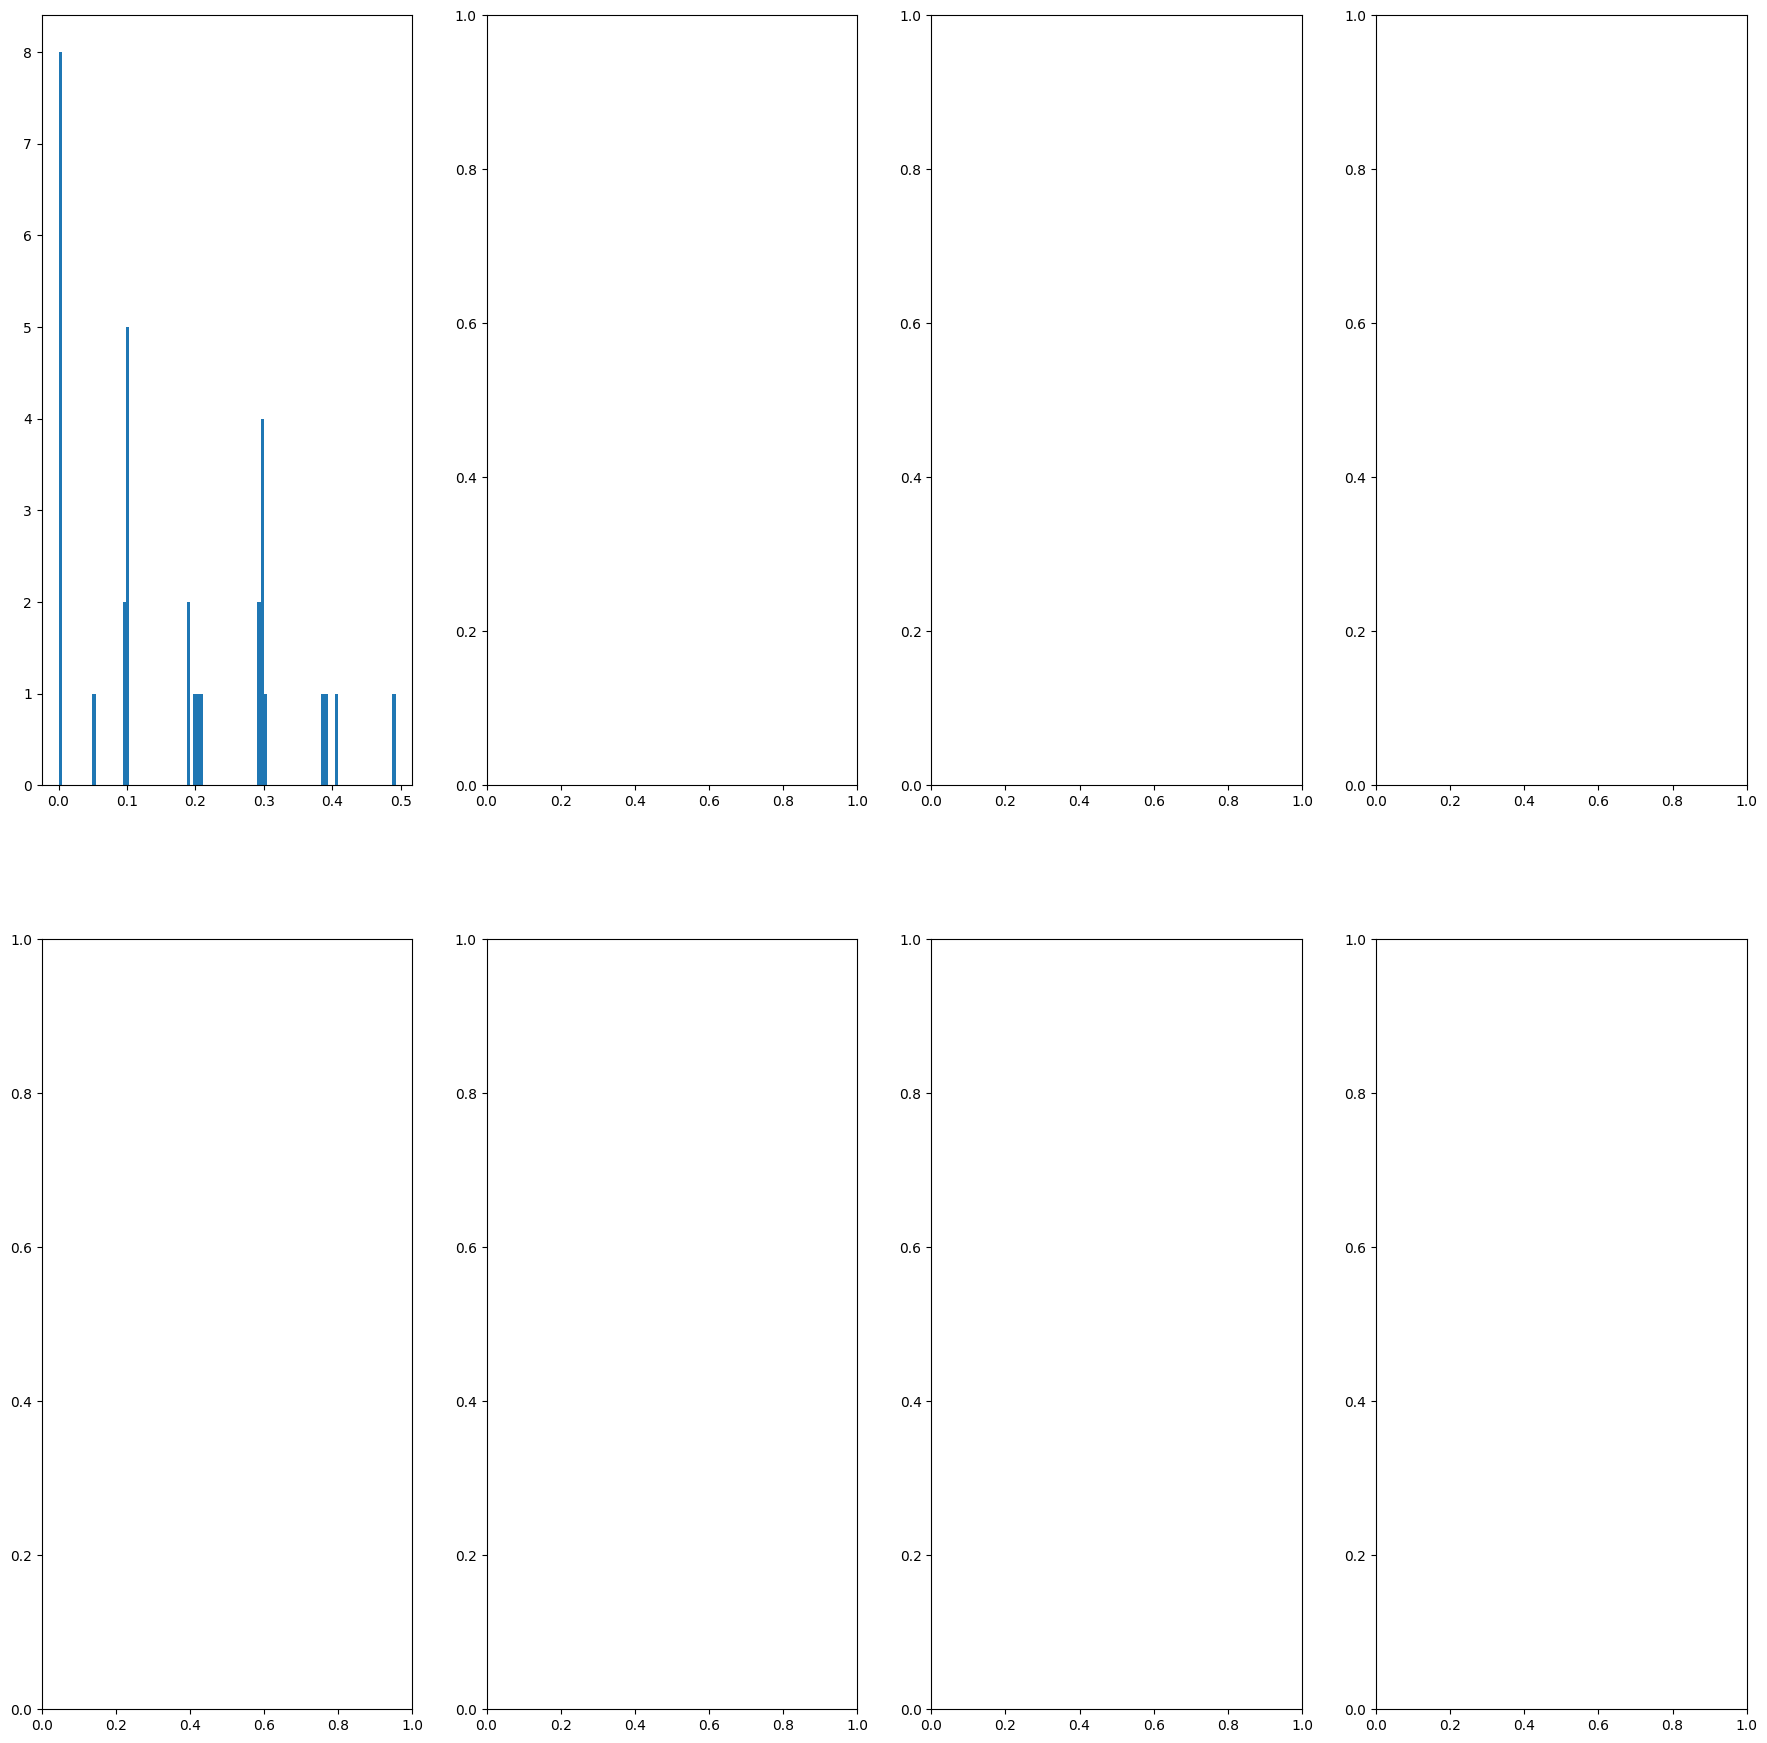

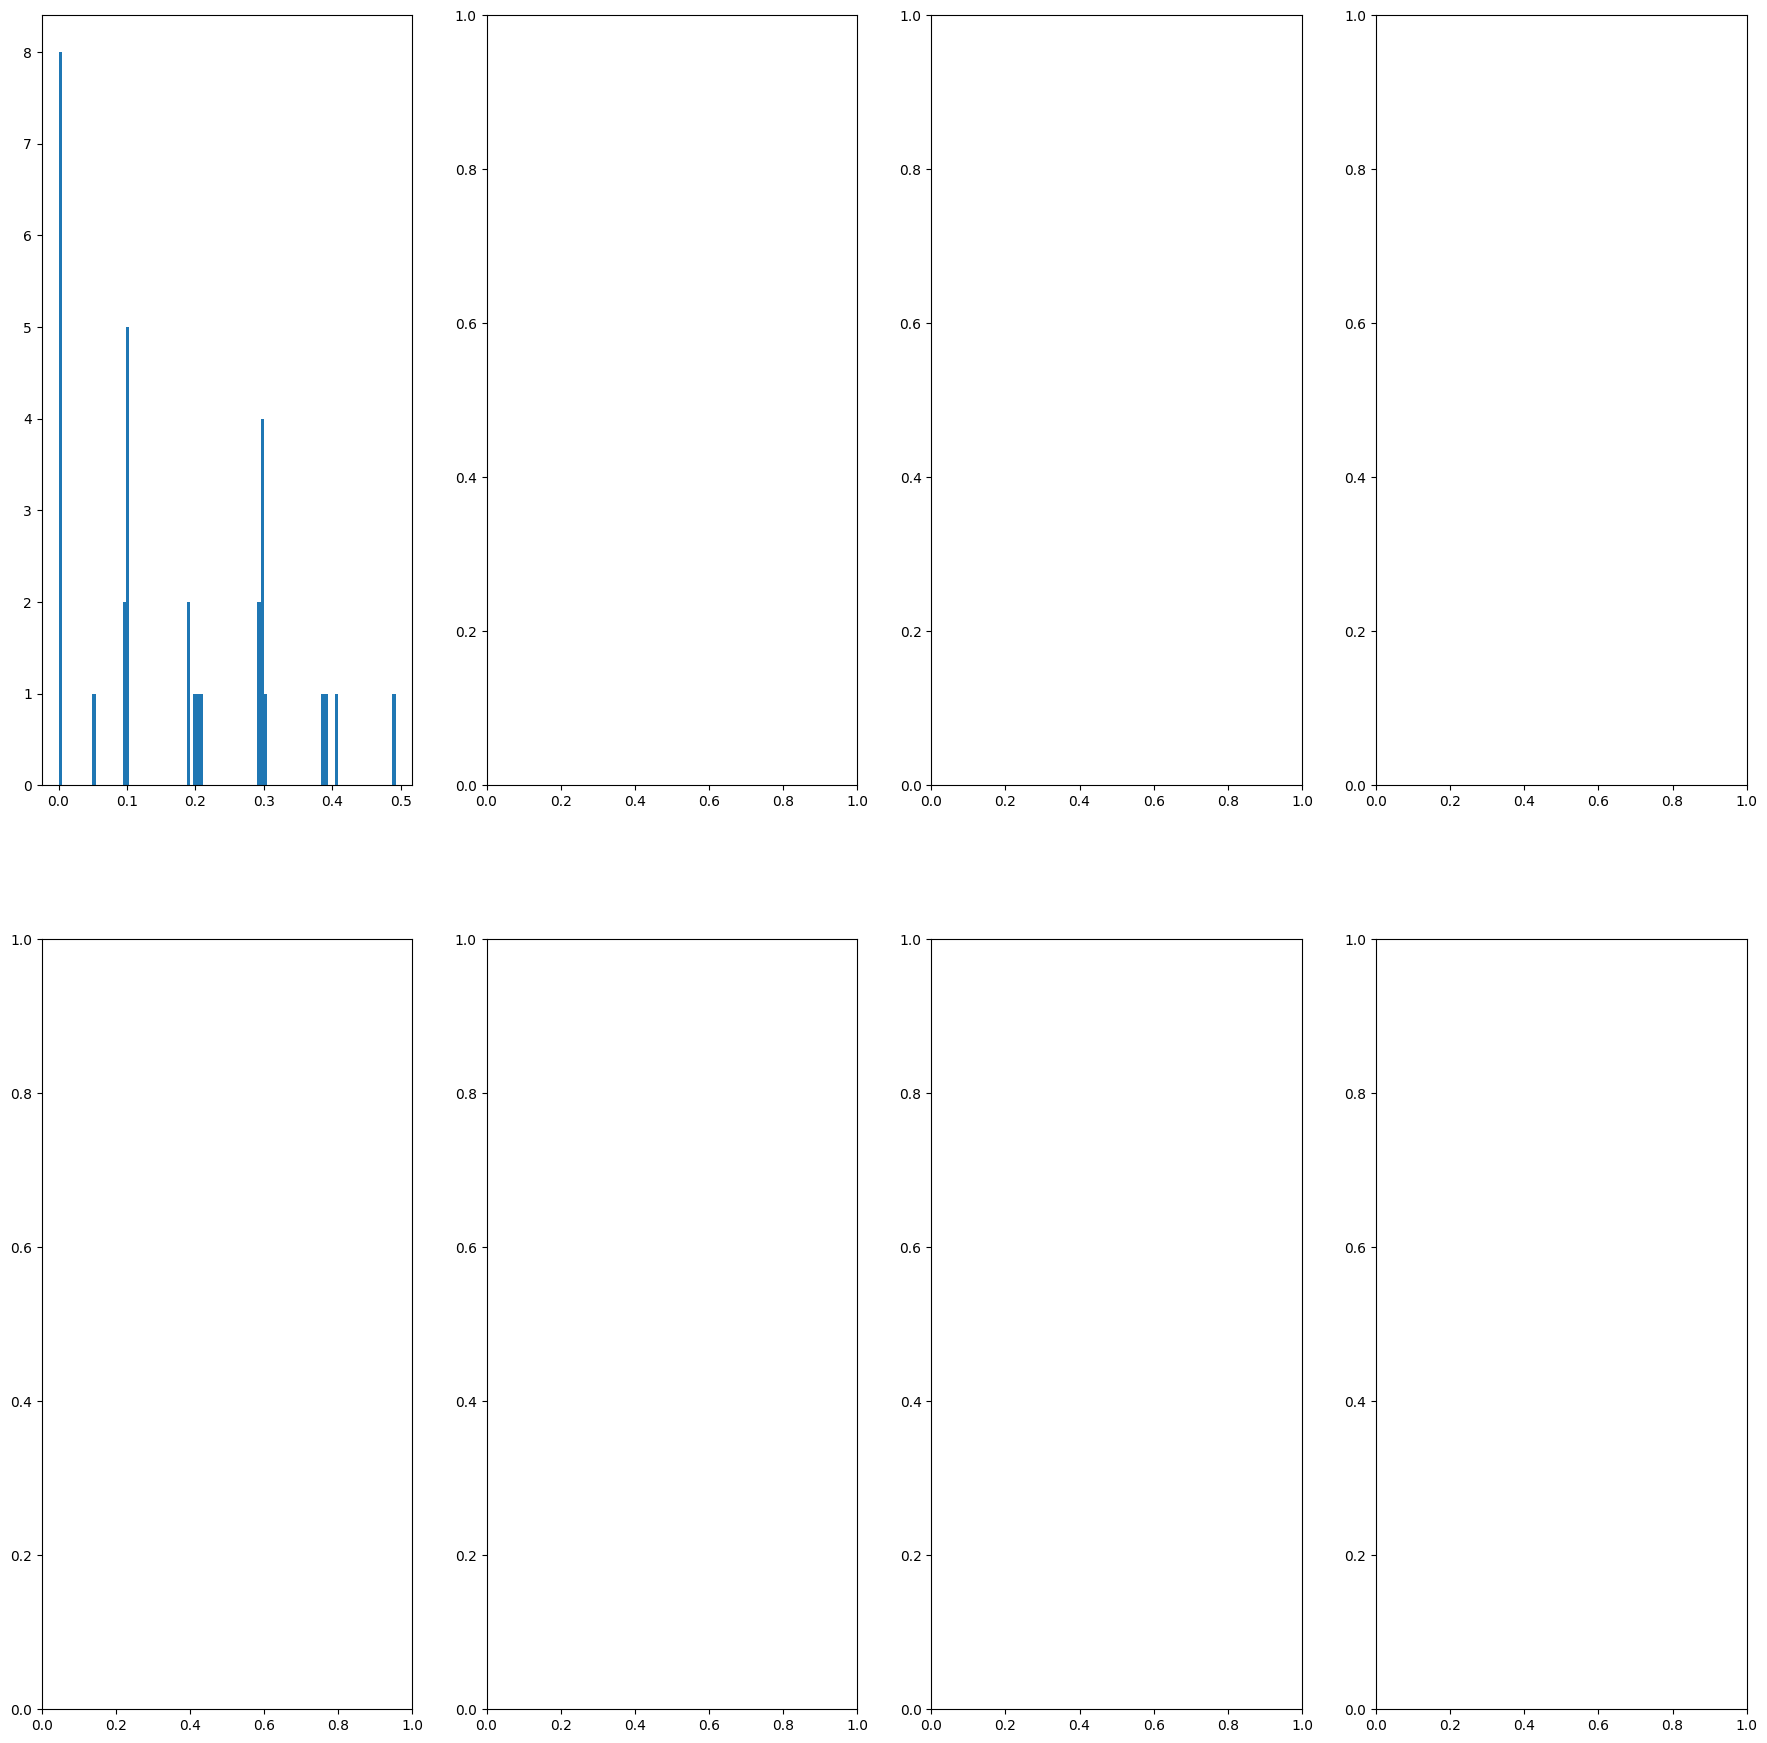

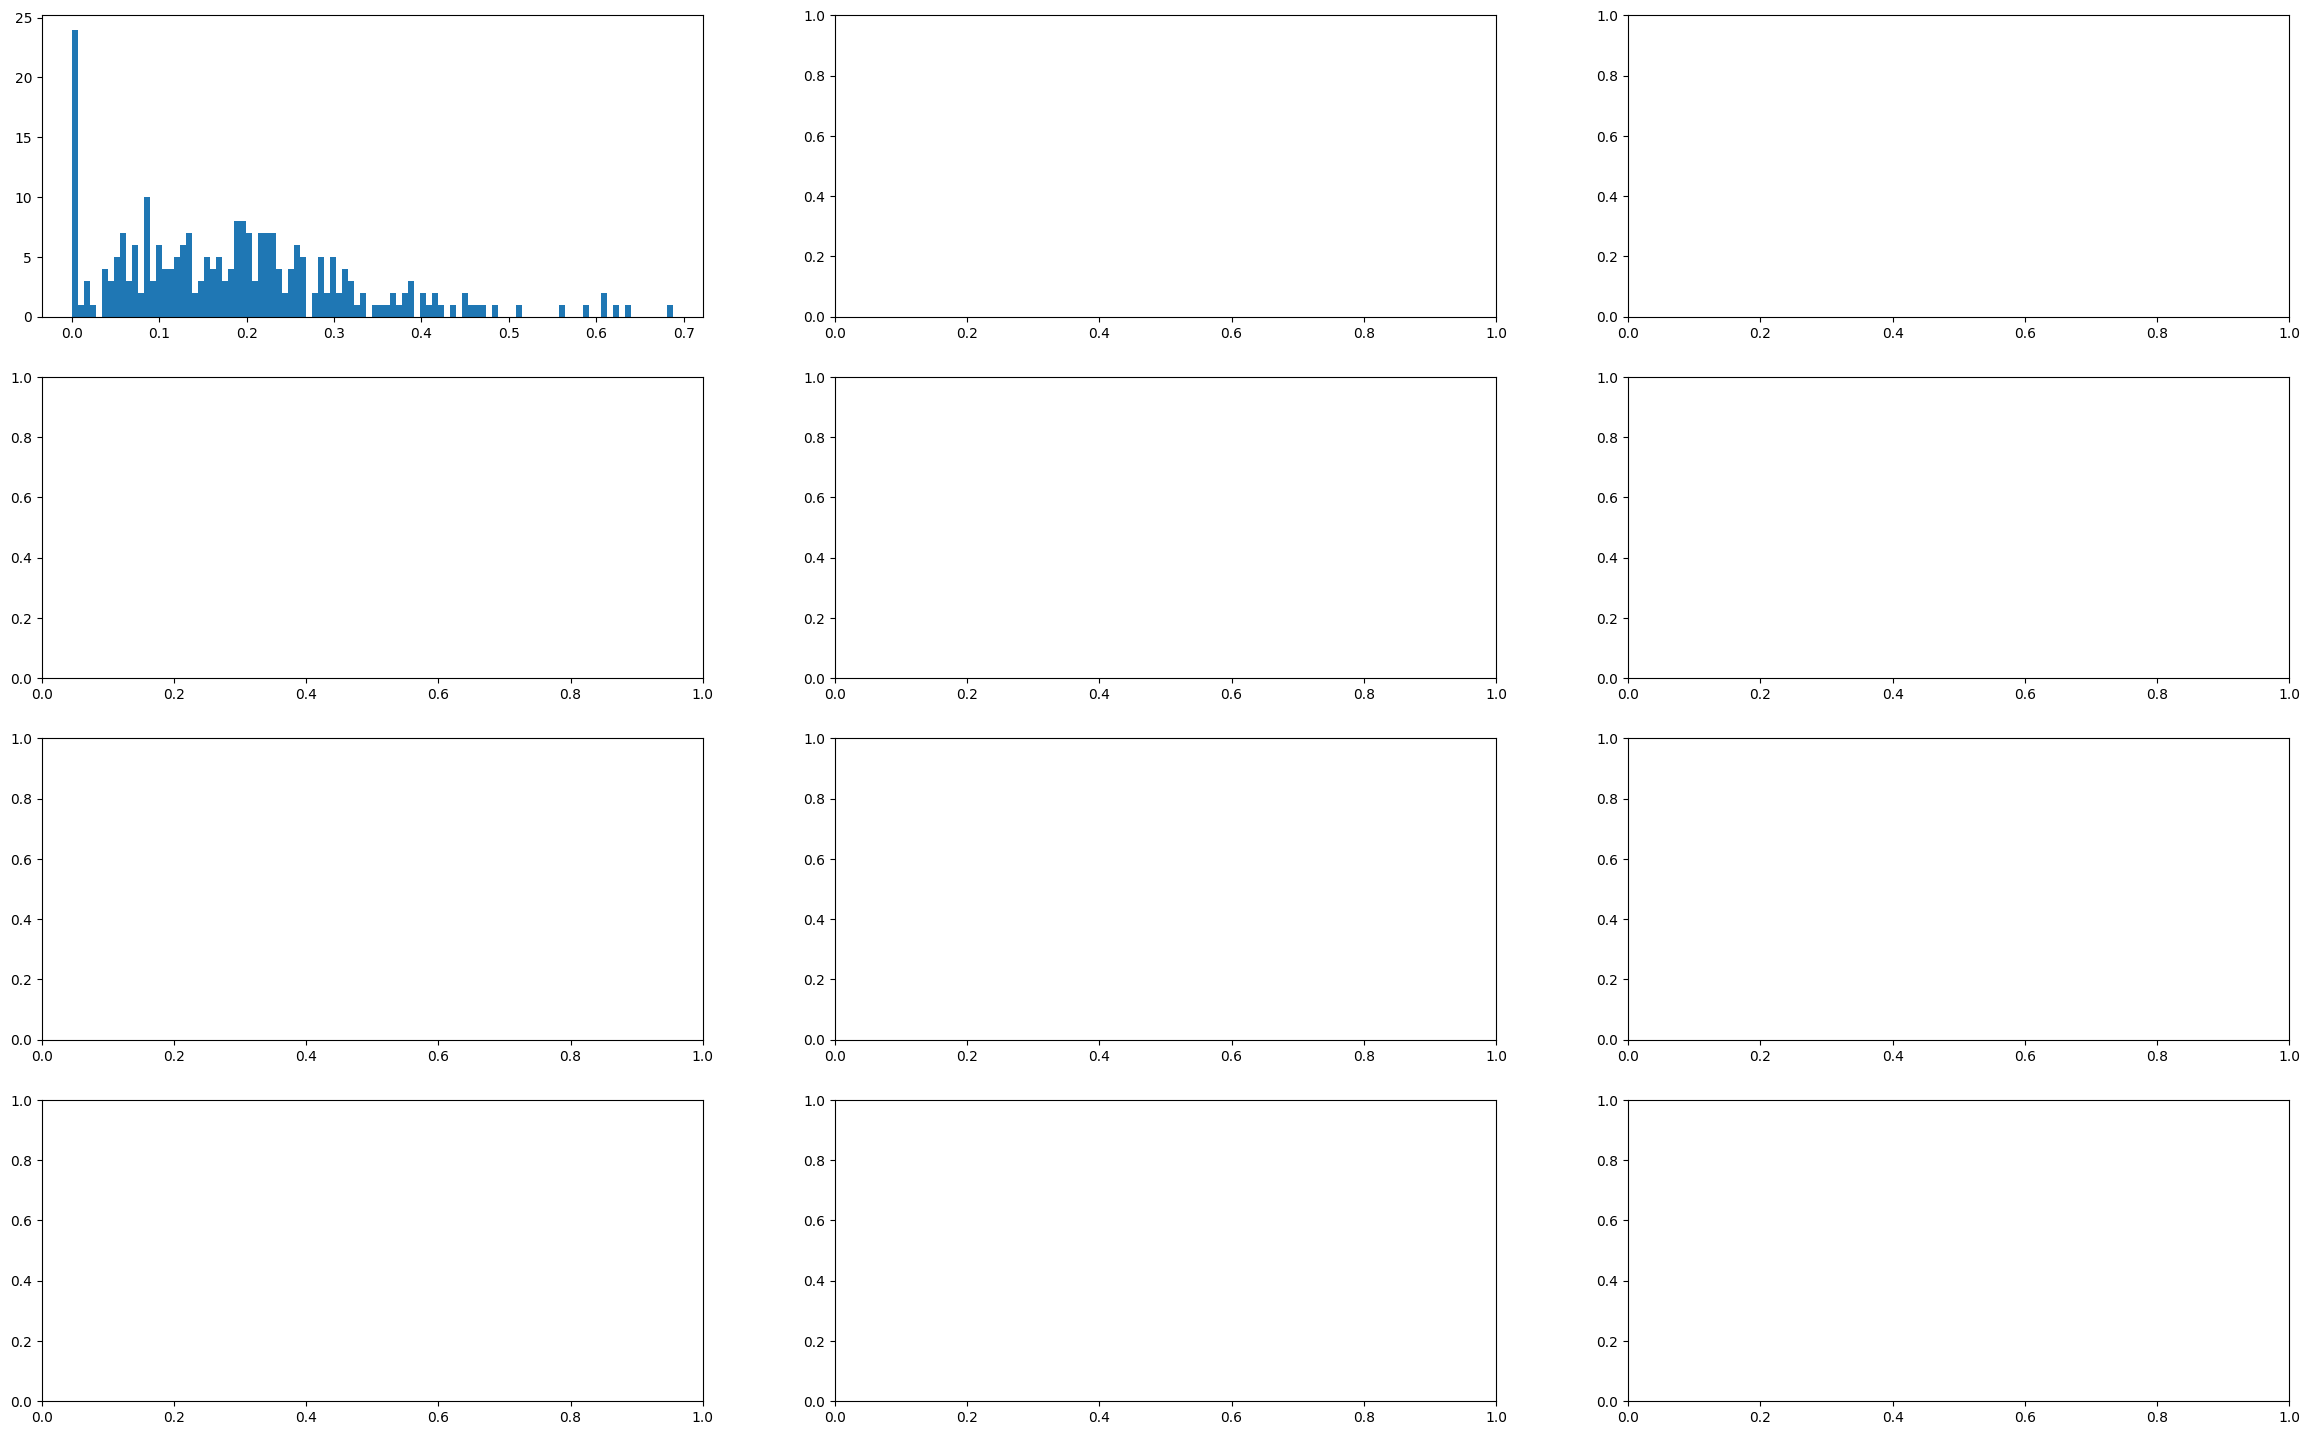

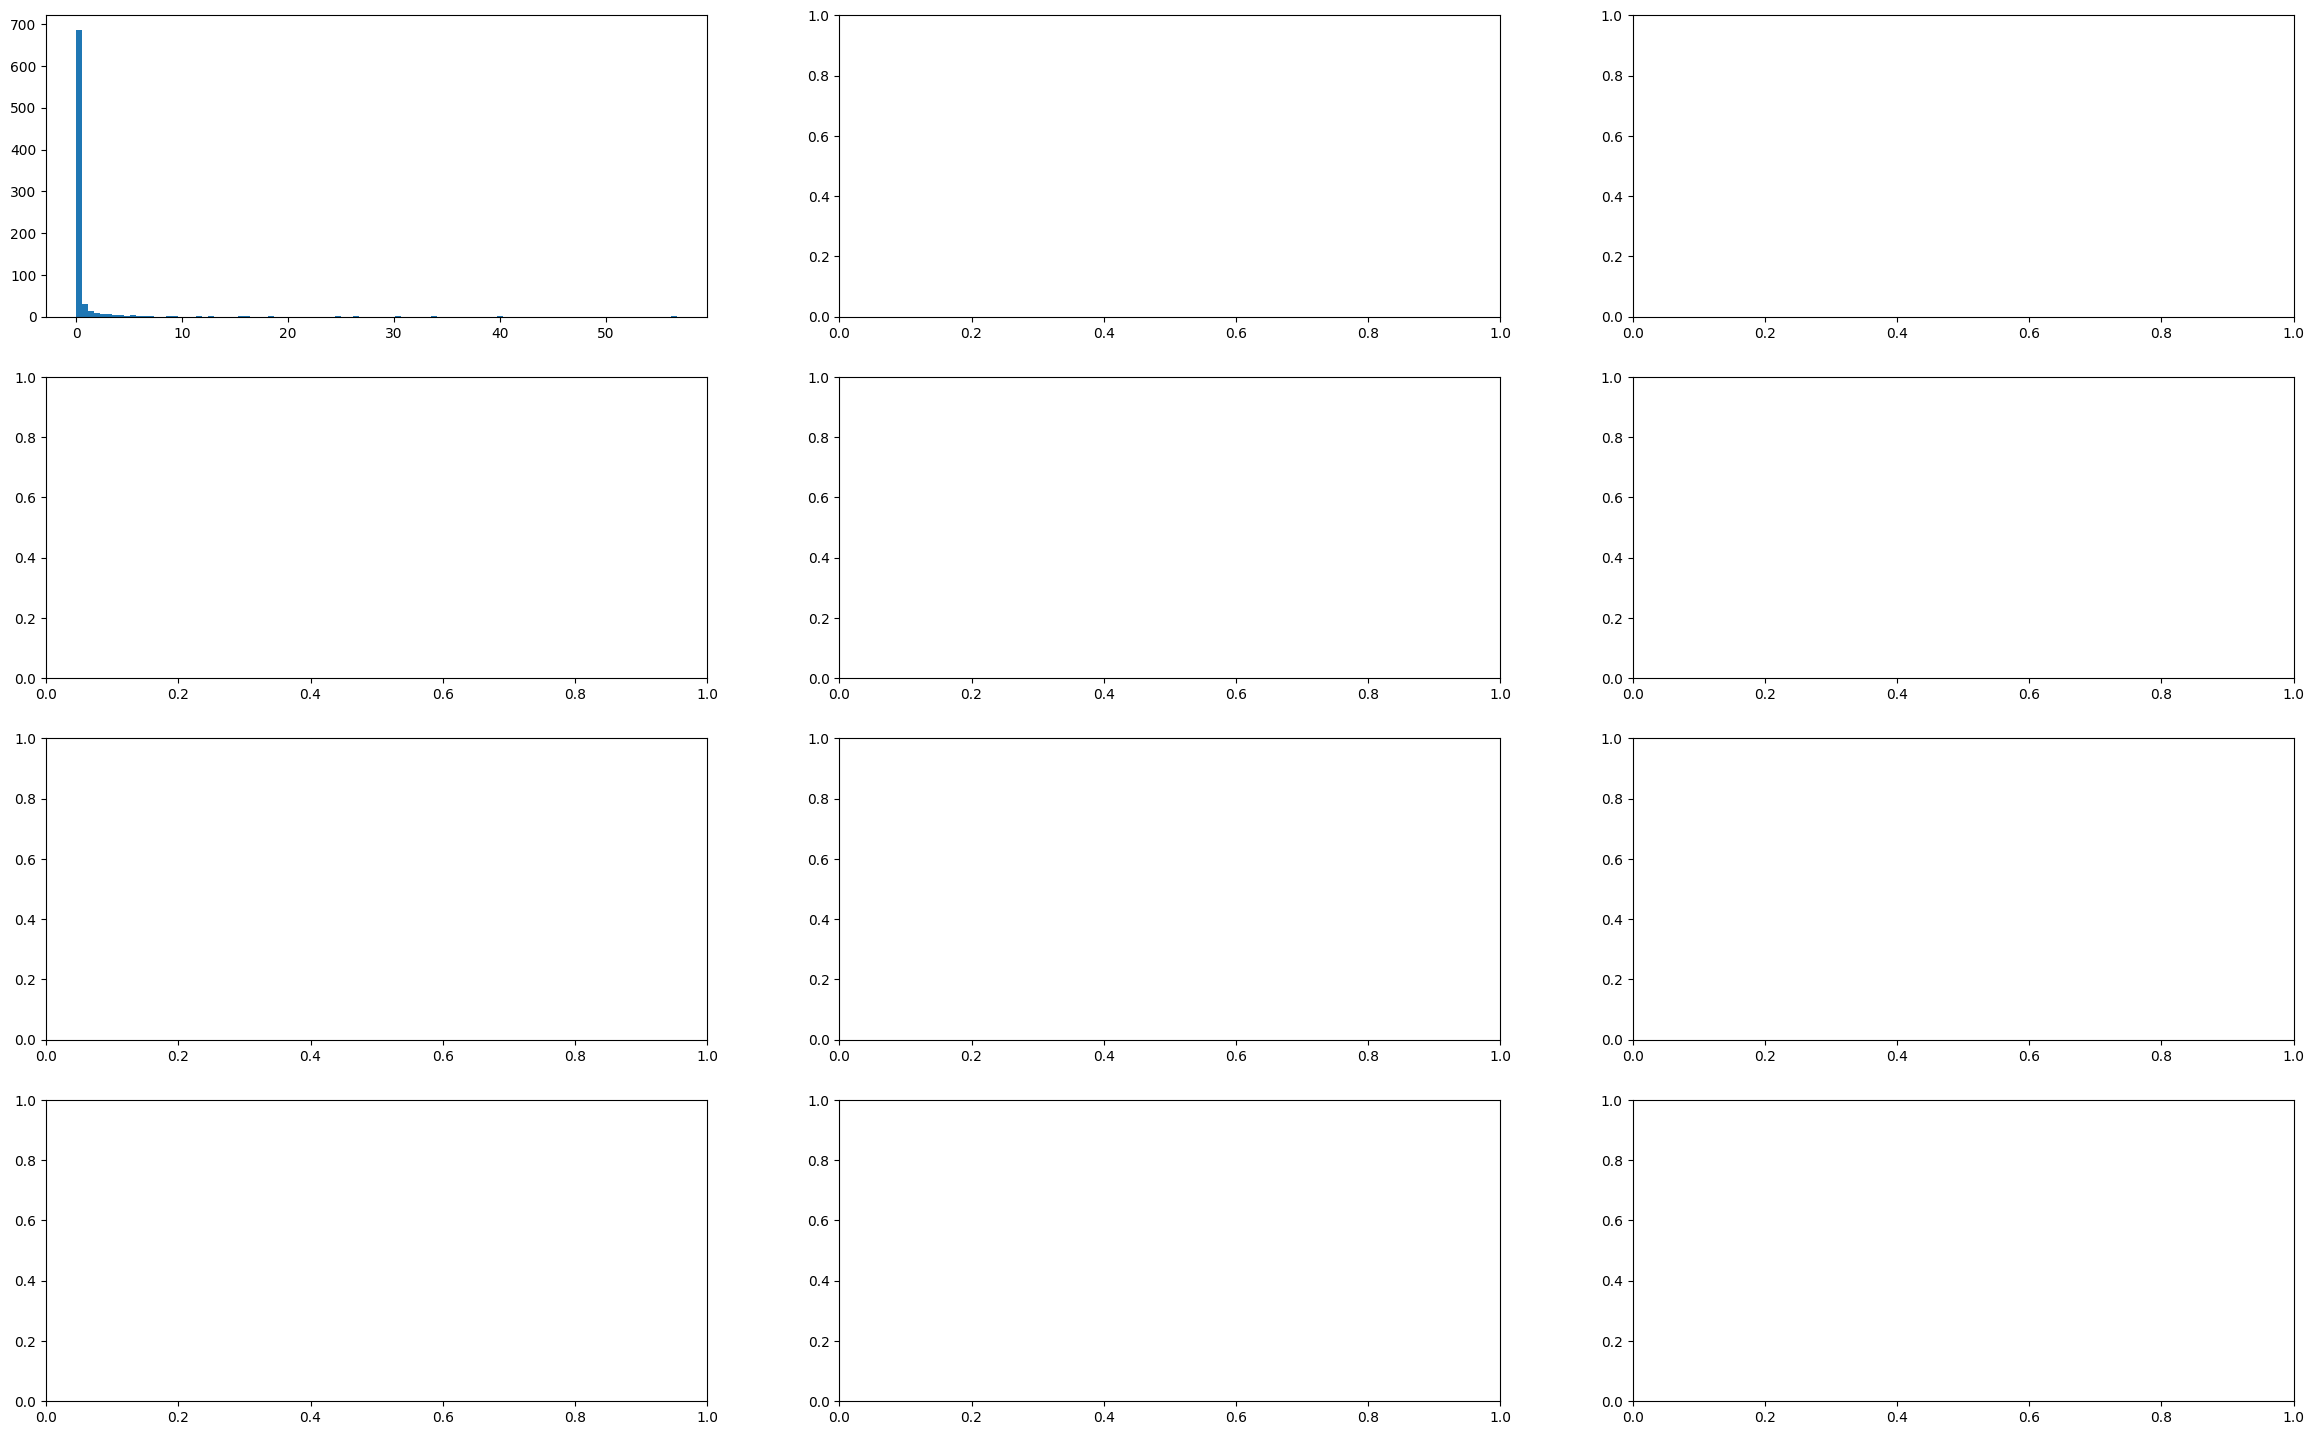

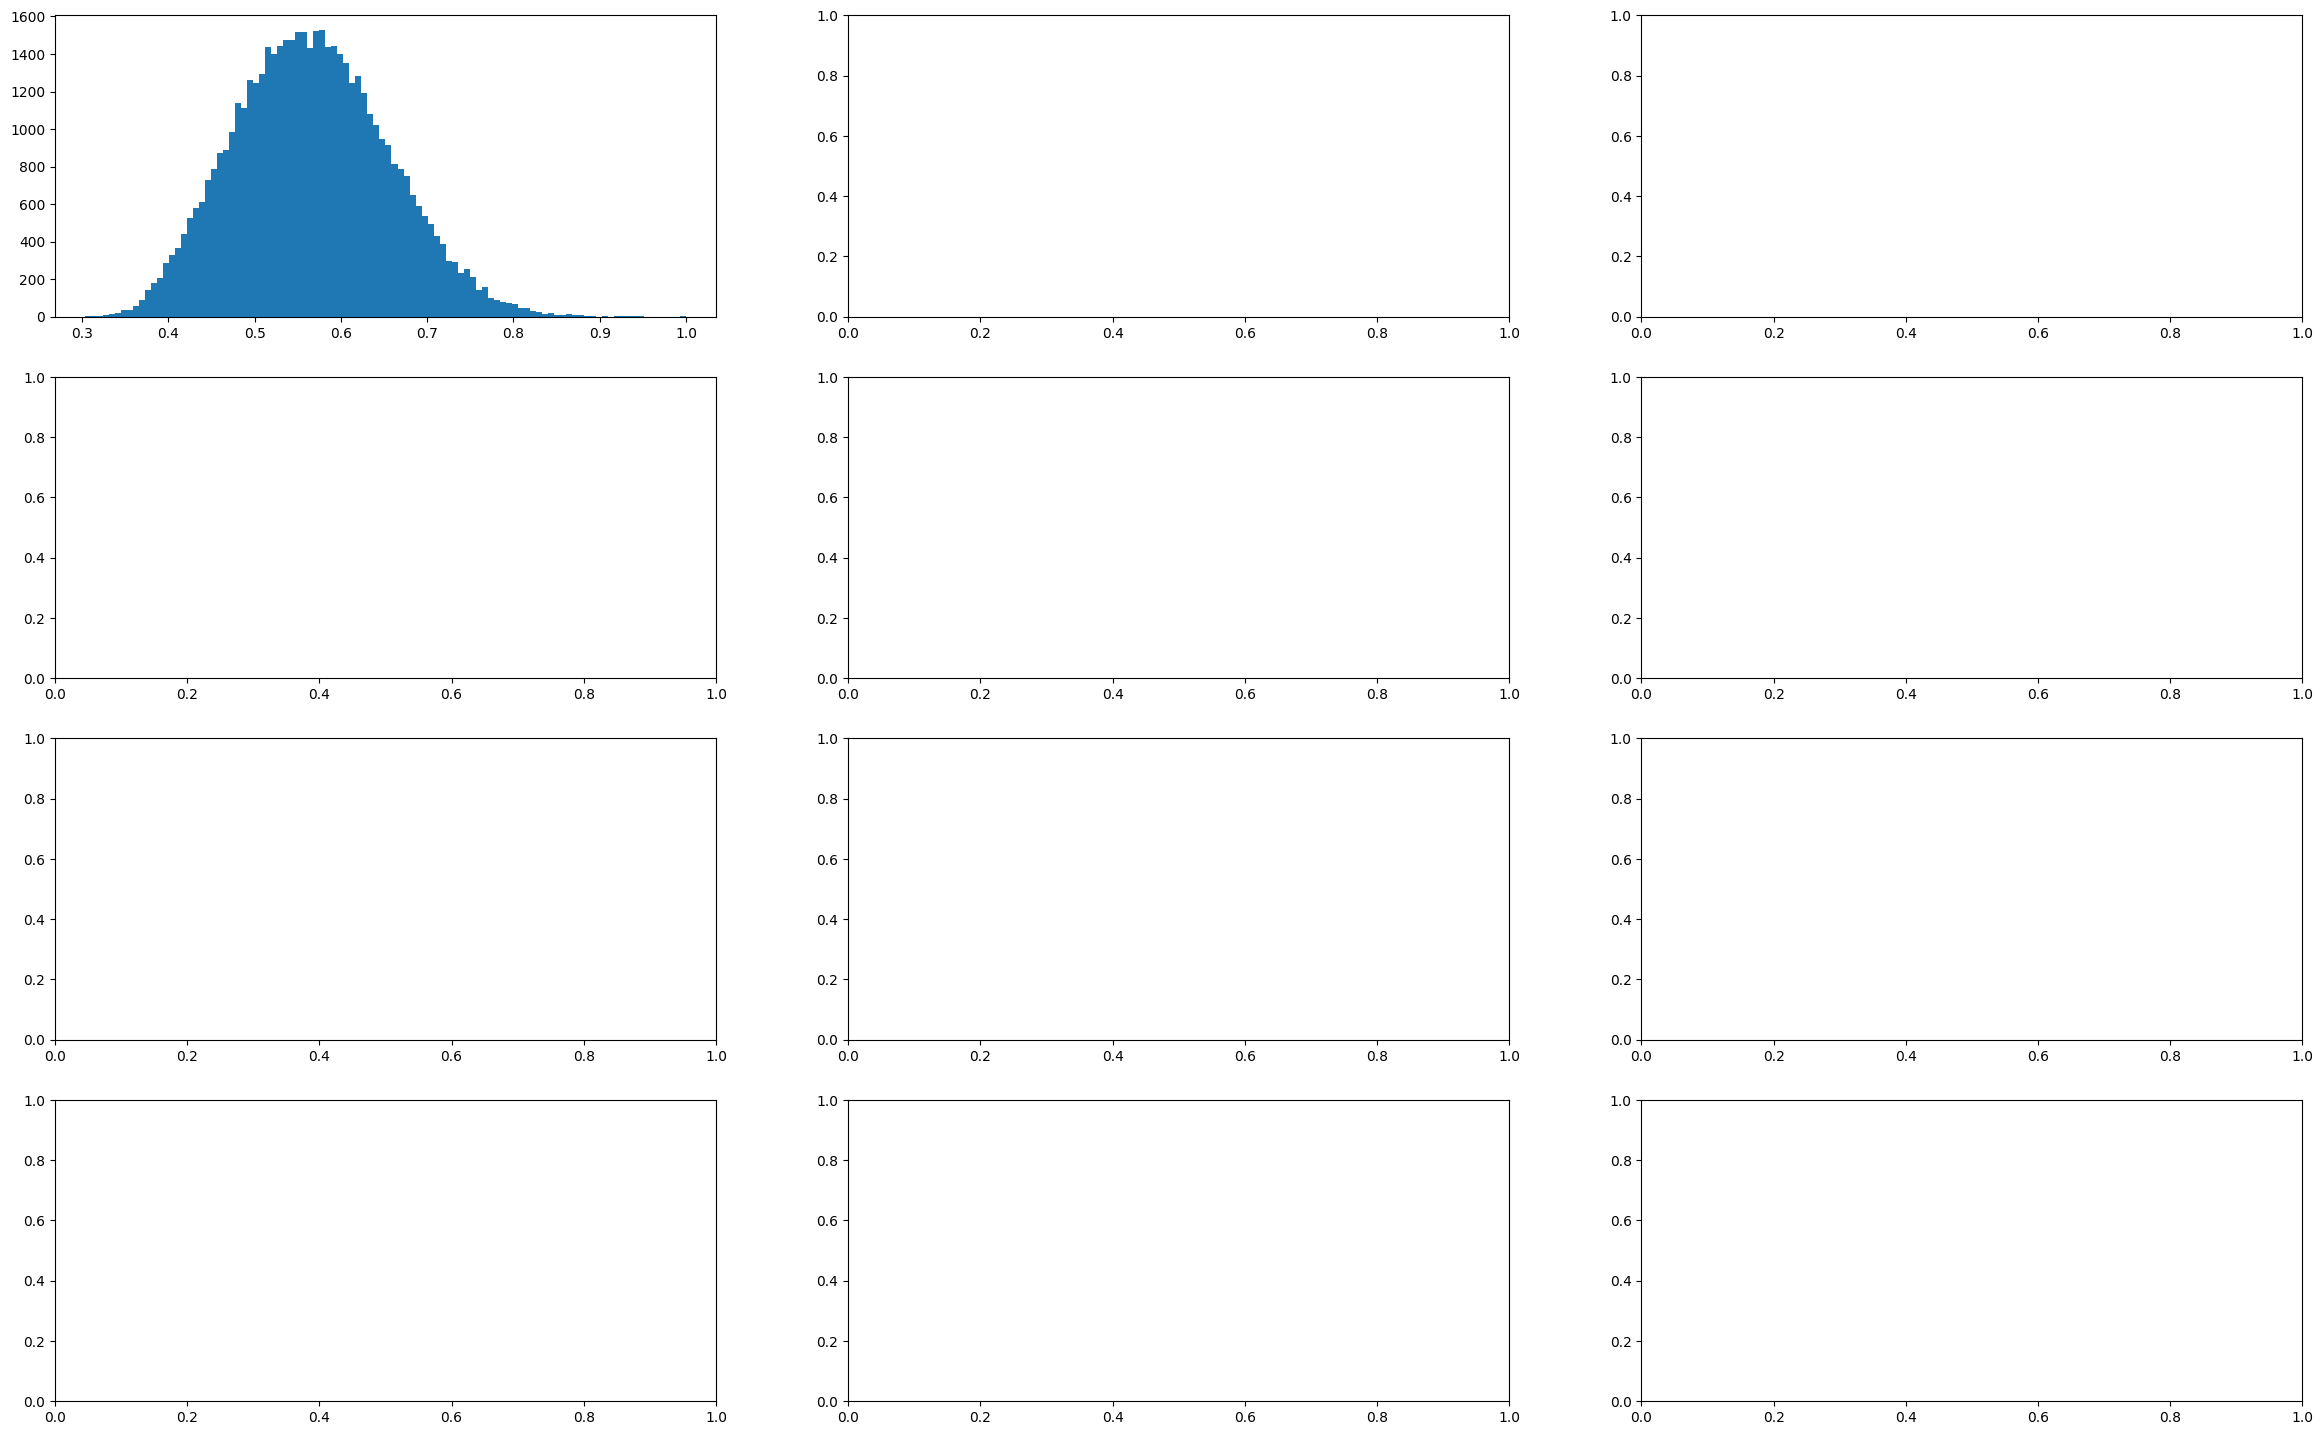

---


In [3]:
anal_path = '../../spike_analysis/spike_samples_25/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, dataset_target_samples, dataset_target_labels, device, '{}_{}'.format(anal_path, 'val_'), 'analyze', plotting=True)
plt.close()
print("---")

In [9]:
mnist_labels =  dataset_target_labels.detach().cpu().numpy()
mnist_data = dataset_target_samples.detach().cpu().numpy().reshape(dataset_target_samples.shape[0], 28 * 28)
# Number of classes
num_classes = len(np.unique(mnist_labels))
key = 'representations'
results_dict['representations']

for idx_layer in tqdm(range(len(results_dict[key]))):

    # mnist_target_data = np.array(results_dict[key][idx_layer]).transpose()
    mnist_target_data = results_dict[key][idx_layer].detach().cpu().numpy()

    plot_target_data = np.array(results_dict['pca_2'][idx_layer]).transpose()

    # Create the overall figure
    fig = plt.figure(figsize=(36, 50))
    outer_grid = fig.add_gridspec(num_classes + 1, 2, width_ratios=[1.2, 1.8], height_ratios=[1] + [0.6] * num_classes)


    # Original PCA plot for the entire dataset
    ax_pca = fig.add_subplot(outer_grid[0, 0])
    ax_pca.set_title('2D PCA of Original MNIST Dataset')

    colors = np.array(plot_data_projection(ax_pca, idx_layer, results_dict['pca_2'], labels_all=results_dict['labels']))


    # Process each class for clustering and sample visualization
    for class_idx in range(num_classes):
        # Extract the data points belonging to the current class
        class_data_indices = np.where(mnist_labels == class_idx)[0]
        class_data = mnist_data[class_data_indices]
        mnist_class_data = mnist_target_data[np.where(mnist_labels == class_idx)[0]]

        plot_class_data = plot_target_data[np.where(mnist_labels == class_idx)[0]]

        points = class_data.copy()

        # Apply iterative line fitting clustering to the class data
        # clusters, cluster_indices = iterative_line_fitting(class_data)
        detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)
        if len(detected_hyperplanes) == 0:
            continue
        assignments, _, _ = assign_points_to_hyperplanes(torch.Tensor(points), detected_hyperplanes)

        # Plot the clustering for the current class
        class_cluster_ax = fig.add_subplot(outer_grid[class_idx + 1, 0])
        class_cluster_ax.set_title(f'Clustering of Class {class_idx} (PCA Reduced)')
        for cluster_idx in range(len(detected_hyperplanes)):
            cluster_color = colors[cluster_idx % len(colors)]
            class_cluster_ax.scatter(plot_class_data[assignments == cluster_idx, 0], plot_class_data[assignments == cluster_idx, 1], label=f'Spike {cluster_idx + 1}', color=cluster_color)
        class_cluster_ax.set_xlabel('First Principal Component')
        class_cluster_ax.set_ylabel('Second Principal Component')
        class_cluster_ax.legend(title='Clusters')

        # Create a grid to hold the sample images for each cluster of the current class
        # sample_grid = fig.add_subplot(outer_grid[class_idx + 1, 1])
        cluster_gridspec = gridspec.GridSpecFromSubplotSpec(1, len(detected_hyperplanes), subplot_spec=outer_grid[class_idx + 1, 1], wspace=0.3)

        for cluster_idx in range(len(detected_hyperplanes)):
            cluster = class_data[assignments == cluster_idx]
            # Create a subplot for each cluster to contain its samples
            cluster_ax = fig.add_subplot(cluster_gridspec[0, cluster_idx])
            cluster_ax.axis('off')
            cluster_ax.set_title(f'Cluster {cluster_idx + 1}', fontsize=10)

            # Plot 15 random samples for the current cluster in a 3x5 grid
            num_samples = min(60, len(cluster))
            rows, cols = 6, 10
            grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=cluster_gridspec[0, cluster_idx], wspace=0.1, hspace=0.1)

            for sample_idx in range(num_samples):
                random_idx = np.random.choice(np.where(assignments == cluster_idx)[0])
                sample_image = class_data[random_idx].reshape(28, 28)
                
                # Determine position within the 3x5 grid
                row, col = divmod(sample_idx, cols)
                sub_ax = fig.add_subplot(grid[row, col])
                sub_ax.imshow(sample_image, cmap='gray')
                sub_ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add spacing to avoid overlap
    fig.savefig(f"{anal_path}spike_plot{idx_layer}.png")
    plt.close()

100%|██████████| 12/12 [17:00<00:00, 85.07s/it]
